# Machine Learning Practical: Coursework 2

**Release date: Wednesday 2nd November 2016**  
**Due date: 16:00 Thursday 24th November 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_2.pdf).

## Part 1: Combining L1 and L2 regularization

Since ```mlp``` thinks I'm in a weird folder, set everything correctly here.

In [53]:
import os
desired_wd = '/Users/sipola/Google Drive/mlpractical'
orig_wd = os.getcwd()
if desired_wd != os.getcwd():
    os.chdir(desired_wd)
print 'working dir: ' + os.getcwd()

os.environ['MLP_DATA_DIR'] = os.path.join(desired_wd, 'data')
print 'data dir: ' + os.environ['MLP_DATA_DIR'] 

working dir: /Users/sipola/Google Drive/mlpractical
data dir: /Users/sipola/Google Drive/mlpractical/data


In [54]:
import matplotlib.pyplot as plt
import pickle

In [55]:
import os.path
import datetime

# print os.getcwd()
# save_path_main = '/afs/inf.ed.ac.uk/user/s16/s1667278/Documents/mlp/coursework2'
save_path_main = 'run/coursework2/'
# save_path_main = '/Users/sipola/mlpractical/my-coursework/coursework2/images/'

def create_and_return_path(folder_name,
                           save_path_main,
                           date_as_str = datetime.datetime.today().strftime('%Y-%m-%d')):
    save_path = os.path.join(save_path_main, folder_name, date_as_str)
    print 'path created: ' + save_path
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    return save_path


import os

def clear_dir(folder):
    print 'deleting files in: ' + folder
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [12]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

L1 and L2 penalty code from lab 5.

In [3]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)

In [4]:
from collections import OrderedDict
from mlp.layers import ReluLayer, AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

# num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

"Original" code from lab 5.

In [13]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 0.83s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00


KeyboardInterrupt: 

Testing different regularization values. Iterate over each of the three layers.

In [18]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'l1_l2_penalties'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_epochs = 100

weights_penalties = [
    None,
    L1Penalty(1e-5),
    L2Penalty(1e-4)
]

penalty_combos = []
penalty_strs = []
run_info = []
models = []
for weights_penalty1 in weights_penalties:
    for weights_penalty2 in weights_penalties:
        for weights_penalty3 in weights_penalties:
            
            penalty_str = str(weights_penalty1) + '-' + str(weights_penalty2) + '-' + str(weights_penalty3)
            penalty_strs.append(penalty_str)
            penalty_combos.append((weights_penalty1, weights_penalty2, weights_penalty3))
            
            # Reset random number generator and data provider states on each run
            # to ensure reproducibility of results
            rng.seed(seed)
            train_data.reset()
            valid_data.reset()
            
            penalties_str = '{0}'.format(weights_penalty1) + ', ' + \
                            '{0}'.format(weights_penalty2) + ', ' + \
                            '{0}'.format(weights_penalty3)
            
            print penalties_str
            model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, 
                            biases_init, weights_penalty1),
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, 
                            biases_init, weights_penalty2),
                ReluLayer(),
                AffineLayer(hidden_dim, output_dim, weights_init, 
                            biases_init, weights_penalty3)
            ])
            optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
            
            # Run the optimiser for 5 epochs (full passes through the training set)
            # printing statistics every epoch.
            run_info_i = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
            stats, keys, run_time = run_info_i
            
            # Plot the change in the validation and training set error over training.
            fig_1 = plt.figure(figsize=(8, 4))
            ax_1 = fig_1.add_subplot(111)
            for k in ['error(train)', 'error(valid)']:
                ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                          stats[1:, keys[k]], label=k)
            ax_1.legend(loc=0)
            ax_1.set_xlabel('Epoch number')
            fig_1.suptitle('Penalties by layer: ' + penalties_str)
            
            plt.savefig(os.path.join(save_path, 'error_' + penalties_str + '.pdf'))
            
            # Plot the change in the validation and training set accuracy over training.
            fig_2 = plt.figure(figsize=(8, 4))
            ax_2 = fig_2.add_subplot(111)
            for k in ['acc(train)', 'acc(valid)']:
                ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                          stats[1:, keys[k]], label=k)
            ax_2.legend(loc=0)
            ax_2.set_xlabel('Epoch number')
            fig_2.suptitle('Penalties by layer: ' + penalties_str)
            
            plt.savefig(os.path.join(save_path, 'acc_' + penalties_str + '.pdf'))

    
            run_info.append(run_info_i)
            models.append(model)

# Pickle all important objects
pickle.dump(penalty_combos, open(os.path.join(save_path_main, subdir, "penalty_combos.p"), "wb"))
pickle.dump(penalty_strs,   open(os.path.join(save_path_main, subdir, "penalty_strs.p"), "wb"))
pickle.dump(run_info,       open(os.path.join(save_path_main, subdir, "run_info.p"), "wb"))
pickle.dump(models,         open(os.path.join(save_path_main, subdir, "models.p"), "wb"))

path created: run/coursework2/l1_l2_penalties/2016-11-10
deleting files in: run/coursework2/l1_l2_penalties/2016-11-10
None, None, None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 1.86s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.91s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.96s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 2.05s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.94s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.98s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 2.34s to complet

None, None, L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=5.83e-04
Epoch 5: 1.65s to complete
  error(train)=6.39e-02, acc(train)=9.82e-01, error(valid)=9.60e-02, acc(valid)=9.72e-01, params_penalty=1.79e-03
Epoch 10: 1.64s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.09e-02, acc(valid)=9.77e-01, params_penalty=2.03e-03
Epoch 15: 2.40s to complete
  error(train)=1.16e-02, acc(train)=9.97e-01, error(valid)=8.71e-02, acc(valid)=9.77e-01, params_penalty=2.19e-03
Epoch 20: 2.05s to complete
  error(train)=4.16e-03, acc(train)=1.00e+00, error(valid)=9.56e-02, acc(valid)=9.77e-01, params_penalty=2.29e-03
Epoch 25: 1.58s to complete
  error(train)=1.50e-03, acc(train)=1.00e+00, error(valid)=9.43e-02, acc(valid)=9.79e-01, params_penalty=2.34e-03
Epoch 30: 1.60s to complete
  error(train)=1.03e-03, acc(train)=1.00e+00, error(valid)=1.00e-01, acc(valid)=9.78e-01, params_penalty=2.36e-03
Epoch 35: 2.04s to complet

None, None, L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.26e-04
Epoch 5: 1.75s to complete
  error(train)=6.42e-02, acc(train)=9.82e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01, params_penalty=2.48e-03
Epoch 10: 1.79s to complete
  error(train)=2.53e-02, acc(train)=9.93e-01, error(valid)=8.32e-02, acc(valid)=9.77e-01, params_penalty=3.18e-03
Epoch 15: 1.54s to complete
  error(train)=1.19e-02, acc(train)=9.97e-01, error(valid)=8.61e-02, acc(valid)=9.78e-01, params_penalty=3.65e-03
Epoch 20: 2.41s to complete
  error(train)=4.38e-03, acc(train)=1.00e+00, error(valid)=9.26e-02, acc(valid)=9.78e-01, params_penalty=3.90e-03
Epoch 25: 1.54s to complete
  error(train)=2.12e-03, acc(train)=1.00e+00, error(valid)=9.32e-02, acc(valid)=9.78e-01, params_penalty=3.95e-03
Epoch 30: 1.54s to complete
  error(train)=1.45e-03, acc(train)=1.00e+00, error(valid)=9.62e-02, acc(valid)=9.78e-01, params_penalty=3.89e-03
Epoch 35: 1.52s to complet

None, L1Penalty(1e-05), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=4.34e-03
Epoch 5: 1.56s to complete
  error(train)=6.44e-02, acc(train)=9.82e-01, error(valid)=9.57e-02, acc(valid)=9.72e-01, params_penalty=6.62e-03
Epoch 10: 1.62s to complete
  error(train)=2.56e-02, acc(train)=9.93e-01, error(valid)=8.29e-02, acc(valid)=9.77e-01, params_penalty=7.19e-03
Epoch 15: 1.64s to complete
  error(train)=1.02e-02, acc(train)=9.98e-01, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=7.47e-03
Epoch 20: 1.64s to complete
  error(train)=4.14e-03, acc(train)=1.00e+00, error(valid)=9.37e-02, acc(valid)=9.77e-01, params_penalty=7.51e-03
Epoch 25: 1.63s to complete
  error(train)=1.84e-03, acc(train)=1.00e+00, error(valid)=9.18e-02, acc(valid)=9.79e-01, params_penalty=7.37e-03
Epoch 30: 1.66s to complete
  error(train)=1.29e-03, acc(train)=1.00e+00, error(valid)=9.61e-02, acc(valid)=9.78e-01, params_penalty=7.16e-03
Epoch 35: 1.66s to complet

None, L1Penalty(1e-05), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=4.92e-03
Epoch 5: 1.62s to complete
  error(train)=6.39e-02, acc(train)=9.82e-01, error(valid)=9.61e-02, acc(valid)=9.73e-01, params_penalty=8.42e-03
Epoch 10: 1.65s to complete
  error(train)=2.43e-02, acc(train)=9.94e-01, error(valid)=8.23e-02, acc(valid)=9.78e-01, params_penalty=9.24e-03
Epoch 15: 1.68s to complete
  error(train)=1.00e-02, acc(train)=9.98e-01, error(valid)=8.33e-02, acc(valid)=9.78e-01, params_penalty=9.70e-03
Epoch 20: 1.64s to complete
  error(train)=4.23e-03, acc(train)=1.00e+00, error(valid)=9.39e-02, acc(valid)=9.77e-01, params_penalty=9.85e-03
Epoch 25: 1.72s to complete
  error(train)=2.02e-03, acc(train)=1.00e+00, error(valid)=9.41e-02, acc(valid)=9.78e-01, params_penalty=9.79e-03
Epoch 30: 1.77s to complete
  error(train)=1.46e-03, acc(train)=1.00e+00, error(valid)=9.90e-02, acc(valid)=9.77e-01, params_penalty=9.63e-03
Epoch 35: 1.64s to complet

None, L1Penalty(1e-05), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=4.56e-03
Epoch 5: 1.54s to complete
  error(train)=6.53e-02, acc(train)=9.82e-01, error(valid)=9.55e-02, acc(valid)=9.72e-01, params_penalty=9.14e-03
Epoch 10: 1.60s to complete
  error(train)=2.54e-02, acc(train)=9.93e-01, error(valid)=8.11e-02, acc(valid)=9.77e-01, params_penalty=1.05e-02
Epoch 15: 2.30s to complete
  error(train)=1.15e-02, acc(train)=9.98e-01, error(valid)=8.21e-02, acc(valid)=9.79e-01, params_penalty=1.13e-02
Epoch 20: 1.64s to complete
  error(train)=4.99e-03, acc(train)=1.00e+00, error(valid)=9.06e-02, acc(valid)=9.78e-01, params_penalty=1.17e-02
Epoch 25: 1.66s to complete
  error(train)=2.52e-03, acc(train)=1.00e+00, error(valid)=8.89e-02, acc(valid)=9.80e-01, params_penalty=1.17e-02
Epoch 30: 1.66s to complete
  error(train)=1.84e-03, acc(train)=1.00e+00, error(valid)=9.17e-02, acc(valid)=9.79e-01, params_penalty=1.15e-02
Epoch 35: 1.71s to complet

None, L2Penalty(0.0001), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.25e-03
Epoch 5: 1.90s to complete
  error(train)=6.31e-02, acc(train)=9.82e-01, error(valid)=9.51e-02, acc(valid)=9.72e-01, params_penalty=3.61e-03
Epoch 10: 1.53s to complete
  error(train)=2.41e-02, acc(train)=9.94e-01, error(valid)=8.19e-02, acc(valid)=9.77e-01, params_penalty=4.45e-03
Epoch 15: 1.97s to complete
  error(train)=1.06e-02, acc(train)=9.98e-01, error(valid)=8.57e-02, acc(valid)=9.78e-01, params_penalty=4.95e-03
Epoch 20: 2.64s to complete
  error(train)=4.44e-03, acc(train)=1.00e+00, error(valid)=9.24e-02, acc(valid)=9.78e-01, params_penalty=5.13e-03
Epoch 25: 1.78s to complete
  error(train)=2.03e-03, acc(train)=1.00e+00, error(valid)=8.99e-02, acc(valid)=9.79e-01, params_penalty=5.08e-03
Epoch 30: 1.86s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.41e-02, acc(valid)=9.79e-01, params_penalty=4.91e-03
Epoch 35: 1.84s to complet

None, L2Penalty(0.0001), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.84e-03
Epoch 5: 1.63s to complete
  error(train)=6.44e-02, acc(train)=9.81e-01, error(valid)=9.62e-02, acc(valid)=9.73e-01, params_penalty=5.42e-03
Epoch 10: 1.77s to complete
  error(train)=2.48e-02, acc(train)=9.94e-01, error(valid)=8.18e-02, acc(valid)=9.77e-01, params_penalty=6.53e-03
Epoch 15: 1.79s to complete
  error(train)=1.06e-02, acc(train)=9.98e-01, error(valid)=8.26e-02, acc(valid)=9.79e-01, params_penalty=7.21e-03
Epoch 20: 1.79s to complete
  error(train)=4.27e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=7.52e-03
Epoch 25: 1.74s to complete
  error(train)=2.43e-03, acc(train)=1.00e+00, error(valid)=8.95e-02, acc(valid)=9.78e-01, params_penalty=7.55e-03
Epoch 30: 1.59s to complete
  error(train)=1.59e-03, acc(train)=1.00e+00, error(valid)=9.18e-02, acc(valid)=9.79e-01, params_penalty=7.44e-03
Epoch 35: 1.66s to complet

None, L2Penalty(0.0001), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.48e-03
Epoch 5: 1.60s to complete
  error(train)=6.43e-02, acc(train)=9.82e-01, error(valid)=9.57e-02, acc(valid)=9.72e-01, params_penalty=6.15e-03
Epoch 10: 1.73s to complete
  error(train)=2.54e-02, acc(train)=9.93e-01, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=7.77e-03
Epoch 15: 2.52s to complete
  error(train)=1.16e-02, acc(train)=9.98e-01, error(valid)=8.35e-02, acc(valid)=9.78e-01, params_penalty=8.83e-03
Epoch 20: 1.65s to complete
  error(train)=5.24e-03, acc(train)=1.00e+00, error(valid)=8.99e-02, acc(valid)=9.78e-01, params_penalty=9.38e-03
Epoch 25: 1.59s to complete
  error(train)=2.90e-03, acc(train)=1.00e+00, error(valid)=8.92e-02, acc(valid)=9.78e-01, params_penalty=9.52e-03
Epoch 30: 1.64s to complete
  error(train)=2.14e-03, acc(train)=1.00e+00, error(valid)=9.03e-02, acc(valid)=9.79e-01, params_penalty=9.44e-03
Epoch 35: 1.57s to complet

L1Penalty(1e-05), None, None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.61e-02
Epoch 5: 2.46s to complete
  error(train)=6.45e-02, acc(train)=9.81e-01, error(valid)=9.57e-02, acc(valid)=9.72e-01, params_penalty=2.04e-02
Epoch 10: 2.44s to complete
  error(train)=2.56e-02, acc(train)=9.93e-01, error(valid)=8.13e-02, acc(valid)=9.78e-01, params_penalty=2.11e-02
Epoch 15: 2.38s to complete
  error(train)=1.35e-02, acc(train)=9.97e-01, error(valid)=8.50e-02, acc(valid)=9.77e-01, params_penalty=2.08e-02
Epoch 20: 2.19s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=9.18e-02, acc(valid)=9.77e-01, params_penalty=1.98e-02
Epoch 25: 2.14s to complete
  error(train)=3.24e-03, acc(train)=1.00e+00, error(valid)=8.81e-02, acc(valid)=9.80e-01, params_penalty=1.82e-02
Epoch 30: 2.12s to complete
  error(train)=1.91e-03, acc(train)=1.00e+00, error(valid)=9.05e-02, acc(valid)=9.79e-01, params_penalty=1.65e-02
Epoch 35: 2.38s to complet

L1Penalty(1e-05), None, L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.67e-02
Epoch 5: 2.22s to complete
  error(train)=6.35e-02, acc(train)=9.82e-01, error(valid)=9.34e-02, acc(valid)=9.73e-01, params_penalty=2.22e-02
Epoch 10: 2.21s to complete
  error(train)=2.57e-02, acc(train)=9.93e-01, error(valid)=7.97e-02, acc(valid)=9.78e-01, params_penalty=2.31e-02
Epoch 15: 2.29s to complete
  error(train)=1.32e-02, acc(train)=9.97e-01, error(valid)=8.54e-02, acc(valid)=9.77e-01, params_penalty=2.30e-02
Epoch 20: 2.31s to complete
  error(train)=5.26e-03, acc(train)=9.99e-01, error(valid)=8.85e-02, acc(valid)=9.79e-01, params_penalty=2.21e-02
Epoch 25: 2.34s to complete
  error(train)=2.88e-03, acc(train)=1.00e+00, error(valid)=8.97e-02, acc(valid)=9.80e-01, params_penalty=2.05e-02
Epoch 30: 2.66s to complete
  error(train)=1.91e-03, acc(train)=1.00e+00, error(valid)=9.11e-02, acc(valid)=9.79e-01, params_penalty=1.90e-02
Epoch 35: 2.53s to complet

L1Penalty(1e-05), None, L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.63e-02
Epoch 5: 2.80s to complete
  error(train)=6.62e-02, acc(train)=9.81e-01, error(valid)=9.57e-02, acc(valid)=9.71e-01, params_penalty=2.29e-02
Epoch 10: 2.23s to complete
  error(train)=2.66e-02, acc(train)=9.93e-01, error(valid)=7.97e-02, acc(valid)=9.77e-01, params_penalty=2.43e-02
Epoch 15: 2.39s to complete
  error(train)=1.32e-02, acc(train)=9.97e-01, error(valid)=8.32e-02, acc(valid)=9.78e-01, params_penalty=2.46e-02
Epoch 20: 2.26s to complete
  error(train)=6.37e-03, acc(train)=9.99e-01, error(valid)=8.88e-02, acc(valid)=9.76e-01, params_penalty=2.40e-02
Epoch 25: 2.31s to complete
  error(train)=3.59e-03, acc(train)=1.00e+00, error(valid)=8.55e-02, acc(valid)=9.79e-01, params_penalty=2.27e-02
Epoch 30: 3.27s to complete
  error(train)=2.50e-03, acc(train)=1.00e+00, error(valid)=8.88e-02, acc(valid)=9.79e-01, params_penalty=2.12e-02
Epoch 35: 2.28s to complet

L1Penalty(1e-05), L1Penalty(1e-05), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.04e-02
Epoch 5: 2.45s to complete
  error(train)=6.50e-02, acc(train)=9.82e-01, error(valid)=9.58e-02, acc(valid)=9.72e-01, params_penalty=2.71e-02
Epoch 10: 2.31s to complete
  error(train)=2.80e-02, acc(train)=9.92e-01, error(valid)=8.27e-02, acc(valid)=9.76e-01, params_penalty=2.83e-02
Epoch 15: 2.41s to complete
  error(train)=1.33e-02, acc(train)=9.97e-01, error(valid)=8.36e-02, acc(valid)=9.78e-01, params_penalty=2.84e-02
Epoch 20: 2.58s to complete
  error(train)=7.56e-03, acc(train)=9.99e-01, error(valid)=9.34e-02, acc(valid)=9.77e-01, params_penalty=2.75e-02
Epoch 25: 2.51s to complete
  error(train)=4.24e-03, acc(train)=1.00e+00, error(valid)=8.83e-02, acc(valid)=9.80e-01, params_penalty=2.60e-02
Epoch 30: 2.27s to complete
  error(train)=2.20e-03, acc(train)=1.00e+00, error(valid)=9.07e-02, acc(valid)=9.79e-01, params_penalty=2.43e-02
Epoch 35: 2.30s to complet

L1Penalty(1e-05), L1Penalty(1e-05), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e-02
Epoch 5: 2.37s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 2.31s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 2.27s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 2.26s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 2.36s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 2.33s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 2.26s to complet

L1Penalty(1e-05), L1Penalty(1e-05), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.06e-02
Epoch 5: 2.60s to complete
  error(train)=6.48e-02, acc(train)=9.82e-01, error(valid)=9.47e-02, acc(valid)=9.73e-01, params_penalty=2.96e-02
Epoch 10: 2.48s to complete
  error(train)=2.70e-02, acc(train)=9.92e-01, error(valid)=7.92e-02, acc(valid)=9.78e-01, params_penalty=3.17e-02
Epoch 15: 2.28s to complete
  error(train)=1.39e-02, acc(train)=9.97e-01, error(valid)=8.00e-02, acc(valid)=9.79e-01, params_penalty=3.23e-02
Epoch 20: 2.53s to complete
  error(train)=7.21e-03, acc(train)=9.99e-01, error(valid)=8.61e-02, acc(valid)=9.77e-01, params_penalty=3.19e-02
Epoch 25: 2.46s to complete
  error(train)=3.80e-03, acc(train)=1.00e+00, error(valid)=8.41e-02, acc(valid)=9.79e-01, params_penalty=3.07e-02
Epoch 30: 2.29s to complete
  error(train)=3.40e-03, acc(train)=1.00e+00, error(valid)=8.72e-02, acc(valid)=9.78e-01, params_penalty=2.94e-02
Epoch 35: 2.39s to complet

L1Penalty(1e-05), L2Penalty(0.0001), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.73e-02
Epoch 5: 2.31s to complete
  error(train)=6.45e-02, acc(train)=9.82e-01, error(valid)=9.49e-02, acc(valid)=9.72e-01, params_penalty=2.41e-02
Epoch 10: 2.24s to complete
  error(train)=2.59e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.77e-01, params_penalty=2.56e-02
Epoch 15: 2.29s to complete
  error(train)=1.16e-02, acc(train)=9.98e-01, error(valid)=8.09e-02, acc(valid)=9.78e-01, params_penalty=2.58e-02
Epoch 20: 2.43s to complete
  error(train)=6.38e-03, acc(train)=9.99e-01, error(valid)=8.93e-02, acc(valid)=9.77e-01, params_penalty=2.51e-02
Epoch 25: 2.30s to complete
  error(train)=3.14e-03, acc(train)=1.00e+00, error(valid)=8.51e-02, acc(valid)=9.80e-01, params_penalty=2.37e-02
Epoch 30: 2.50s to complete
  error(train)=2.54e-03, acc(train)=1.00e+00, error(valid)=8.85e-02, acc(valid)=9.79e-01, params_penalty=2.21e-02
Epoch 35: 2.44s to complet

L1Penalty(1e-05), L2Penalty(0.0001), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.79e-02
Epoch 5: 2.54s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.51e-02, acc(valid)=9.71e-01, params_penalty=2.59e-02
Epoch 10: 2.45s to complete
  error(train)=2.70e-02, acc(train)=9.93e-01, error(valid)=8.13e-02, acc(valid)=9.77e-01, params_penalty=2.77e-02
Epoch 15: 2.32s to complete
  error(train)=1.30e-02, acc(train)=9.97e-01, error(valid)=8.03e-02, acc(valid)=9.79e-01, params_penalty=2.82e-02
Epoch 20: 2.28s to complete
  error(train)=7.02e-03, acc(train)=9.99e-01, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.76e-02
Epoch 25: 2.39s to complete
  error(train)=4.21e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.80e-01, params_penalty=2.64e-02
Epoch 30: 2.62s to complete
  error(train)=3.07e-03, acc(train)=1.00e+00, error(valid)=8.71e-02, acc(valid)=9.79e-01, params_penalty=2.49e-02
Epoch 35: 2.24s to complet

L1Penalty(1e-05), L2Penalty(0.0001), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.76e-02
Epoch 5: 2.45s to complete
  error(train)=6.60e-02, acc(train)=9.81e-01, error(valid)=9.53e-02, acc(valid)=9.72e-01, params_penalty=2.67e-02
Epoch 10: 2.46s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=7.94e-02, acc(valid)=9.77e-01, params_penalty=2.90e-02
Epoch 15: 2.95s to complete
  error(train)=1.50e-02, acc(train)=9.96e-01, error(valid)=8.33e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 20: 3.12s to complete
  error(train)=7.28e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.79e-01, params_penalty=2.96e-02
Epoch 25: 3.20s to complete
  error(train)=4.84e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=2.87e-02
Epoch 30: 2.67s to complete
  error(train)=3.82e-03, acc(train)=1.00e+00, error(valid)=8.54e-02, acc(valid)=9.79e-01, params_penalty=2.75e-02
Epoch 35: 2.56s to complet

L2Penalty(0.0001), None, None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.21e-03
Epoch 5: 2.58s to complete
  error(train)=6.36e-02, acc(train)=9.82e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=5.70e-03
Epoch 10: 1.67s to complete
  error(train)=2.49e-02, acc(train)=9.93e-01, error(valid)=8.16e-02, acc(valid)=9.77e-01, params_penalty=7.43e-03
Epoch 15: 1.75s to complete
  error(train)=1.16e-02, acc(train)=9.98e-01, error(valid)=8.68e-02, acc(valid)=9.78e-01, params_penalty=8.40e-03
Epoch 20: 1.68s to complete
  error(train)=5.31e-03, acc(train)=9.99e-01, error(valid)=9.56e-02, acc(valid)=9.77e-01, params_penalty=8.62e-03
Epoch 25: 2.15s to complete
  error(train)=1.90e-03, acc(train)=1.00e+00, error(valid)=8.83e-02, acc(valid)=9.79e-01, params_penalty=8.30e-03
Epoch 30: 2.12s to complete
  error(train)=1.36e-03, acc(train)=1.00e+00, error(valid)=9.07e-02, acc(valid)=9.79e-01, params_penalty=7.83e-03
Epoch 35: 1.81s to complet

L2Penalty(0.0001), None, L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.79e-03
Epoch 5: 1.96s to complete
  error(train)=6.45e-02, acc(train)=9.82e-01, error(valid)=9.61e-02, acc(valid)=9.72e-01, params_penalty=7.51e-03
Epoch 10: 1.83s to complete
  error(train)=2.51e-02, acc(train)=9.93e-01, error(valid)=8.24e-02, acc(valid)=9.76e-01, params_penalty=9.48e-03
Epoch 15: 2.32s to complete
  error(train)=1.17e-02, acc(train)=9.97e-01, error(valid)=8.39e-02, acc(valid)=9.78e-01, params_penalty=1.06e-02
Epoch 20: 1.78s to complete
  error(train)=5.16e-03, acc(train)=9.99e-01, error(valid)=9.12e-02, acc(valid)=9.77e-01, params_penalty=1.10e-02
Epoch 25: 2.09s to complete
  error(train)=2.39e-03, acc(train)=1.00e+00, error(valid)=8.87e-02, acc(valid)=9.79e-01, params_penalty=1.08e-02
Epoch 30: 1.82s to complete
  error(train)=1.49e-03, acc(train)=1.00e+00, error(valid)=9.08e-02, acc(valid)=9.79e-01, params_penalty=1.04e-02
Epoch 35: 2.07s to complet

L2Penalty(0.0001), None, L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.43e-03
Epoch 5: 1.83s to complete
  error(train)=6.48e-02, acc(train)=9.81e-01, error(valid)=9.60e-02, acc(valid)=9.72e-01, params_penalty=8.22e-03
Epoch 10: 2.05s to complete
  error(train)=2.61e-02, acc(train)=9.93e-01, error(valid)=8.19e-02, acc(valid)=9.77e-01, params_penalty=1.07e-02
Epoch 15: 3.08s to complete
  error(train)=1.12e-02, acc(train)=9.98e-01, error(valid)=8.21e-02, acc(valid)=9.79e-01, params_penalty=1.22e-02
Epoch 20: 2.56s to complete
  error(train)=6.16e-03, acc(train)=9.99e-01, error(valid)=9.25e-02, acc(valid)=9.77e-01, params_penalty=1.27e-02
Epoch 25: 2.20s to complete
  error(train)=2.74e-03, acc(train)=1.00e+00, error(valid)=8.68e-02, acc(valid)=9.79e-01, params_penalty=1.27e-02
Epoch 30: 1.78s to complete
  error(train)=2.00e-03, acc(train)=1.00e+00, error(valid)=8.88e-02, acc(valid)=9.79e-01, params_penalty=1.23e-02
Epoch 35: 1.95s to complet

L2Penalty(0.0001), L1Penalty(1e-05), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=6.54e-03
Epoch 5: 1.95s to complete
  error(train)=6.53e-02, acc(train)=9.82e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01, params_penalty=1.23e-02
Epoch 10: 2.03s to complete
  error(train)=2.57e-02, acc(train)=9.93e-01, error(valid)=8.12e-02, acc(valid)=9.76e-01, params_penalty=1.46e-02
Epoch 15: 2.11s to complete
  error(train)=1.32e-02, acc(train)=9.97e-01, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=1.60e-02
Epoch 20: 2.02s to complete
  error(train)=6.11e-03, acc(train)=9.99e-01, error(valid)=9.08e-02, acc(valid)=9.77e-01, params_penalty=1.64e-02
Epoch 25: 1.84s to complete
  error(train)=2.68e-03, acc(train)=1.00e+00, error(valid)=8.67e-02, acc(valid)=9.79e-01, params_penalty=1.61e-02
Epoch 30: 1.88s to complete
  error(train)=1.82e-03, acc(train)=1.00e+00, error(valid)=8.80e-02, acc(valid)=9.79e-01, params_penalty=1.55e-02
Epoch 35: 1.76s to complet

L2Penalty(0.0001), L1Penalty(1e-05), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=7.13e-03
Epoch 5: 1.84s to complete
  error(train)=6.45e-02, acc(train)=9.82e-01, error(valid)=9.55e-02, acc(valid)=9.72e-01, params_penalty=1.42e-02
Epoch 10: 1.91s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.21e-02, acc(valid)=9.78e-01, params_penalty=1.67e-02
Epoch 15: 1.89s to complete
  error(train)=1.10e-02, acc(train)=9.98e-01, error(valid)=8.12e-02, acc(valid)=9.79e-01, params_penalty=1.82e-02
Epoch 20: 1.83s to complete
  error(train)=5.70e-03, acc(train)=9.99e-01, error(valid)=8.91e-02, acc(valid)=9.77e-01, params_penalty=1.88e-02
Epoch 25: 1.88s to complete
  error(train)=3.03e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01, params_penalty=1.86e-02
Epoch 30: 1.81s to complete
  error(train)=2.00e-03, acc(train)=1.00e+00, error(valid)=8.90e-02, acc(valid)=9.78e-01, params_penalty=1.81e-02
Epoch 35: 1.91s to complet

L2Penalty(0.0001), L1Penalty(1e-05), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=6.77e-03
Epoch 5: 1.85s to complete
  error(train)=6.51e-02, acc(train)=9.81e-01, error(valid)=9.54e-02, acc(valid)=9.72e-01, params_penalty=1.49e-02
Epoch 10: 2.12s to complete
  error(train)=2.66e-02, acc(train)=9.93e-01, error(valid)=8.13e-02, acc(valid)=9.77e-01, params_penalty=1.81e-02
Epoch 15: 2.09s to complete
  error(train)=1.52e-02, acc(train)=9.96e-01, error(valid)=8.52e-02, acc(valid)=9.77e-01, params_penalty=1.99e-02
Epoch 20: 1.83s to complete
  error(train)=6.55e-03, acc(train)=9.99e-01, error(valid)=8.78e-02, acc(valid)=9.77e-01, params_penalty=2.07e-02
Epoch 25: 1.91s to complete
  error(train)=3.41e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=2.08e-02
Epoch 30: 1.81s to complete
  error(train)=2.59e-03, acc(train)=1.00e+00, error(valid)=8.42e-02, acc(valid)=9.78e-01, params_penalty=2.04e-02
Epoch 35: 1.87s to complet

L2Penalty(0.0001), L2Penalty(0.0001), None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.46e-03
Epoch 5: 1.92s to complete
  error(train)=6.48e-02, acc(train)=9.82e-01, error(valid)=9.61e-02, acc(valid)=9.73e-01, params_penalty=9.35e-03
Epoch 10: 1.72s to complete
  error(train)=2.62e-02, acc(train)=9.93e-01, error(valid)=8.27e-02, acc(valid)=9.77e-01, params_penalty=1.19e-02
Epoch 15: 1.92s to complete
  error(train)=1.27e-02, acc(train)=9.97e-01, error(valid)=8.24e-02, acc(valid)=9.78e-01, params_penalty=1.34e-02
Epoch 20: 1.94s to complete
  error(train)=5.99e-03, acc(train)=9.99e-01, error(valid)=9.13e-02, acc(valid)=9.77e-01, params_penalty=1.40e-02
Epoch 25: 1.86s to complete
  error(train)=2.69e-03, acc(train)=1.00e+00, error(valid)=8.70e-02, acc(valid)=9.79e-01, params_penalty=1.38e-02
Epoch 30: 2.02s to complete
  error(train)=2.04e-03, acc(train)=1.00e+00, error(valid)=8.70e-02, acc(valid)=9.79e-01, params_penalty=1.33e-02
Epoch 35: 1.92s to complet

L2Penalty(0.0001), L2Penalty(0.0001), L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=4.05e-03
Epoch 5: 2.03s to complete
  error(train)=6.48e-02, acc(train)=9.82e-01, error(valid)=9.61e-02, acc(valid)=9.72e-01, params_penalty=1.12e-02
Epoch 10: 1.79s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.15e-02, acc(valid)=9.77e-01, params_penalty=1.40e-02
Epoch 15: 1.90s to complete
  error(train)=1.44e-02, acc(train)=9.97e-01, error(valid)=8.64e-02, acc(valid)=9.77e-01, params_penalty=1.58e-02
Epoch 20: 1.74s to complete
  error(train)=6.42e-03, acc(train)=9.99e-01, error(valid)=8.97e-02, acc(valid)=9.78e-01, params_penalty=1.64e-02
Epoch 25: 1.78s to complete
  error(train)=2.97e-03, acc(train)=1.00e+00, error(valid)=8.47e-02, acc(valid)=9.81e-01, params_penalty=1.64e-02
Epoch 30: 1.77s to complete
  error(train)=2.41e-03, acc(train)=1.00e+00, error(valid)=8.64e-02, acc(valid)=9.80e-01, params_penalty=1.60e-02
Epoch 35: 1.74s to complet

L2Penalty(0.0001), L2Penalty(0.0001), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-03
Epoch 5: 1.86s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 2.05s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 1.75s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 1.77s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.85s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 1.90s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 2.21s to complet

In [49]:
for x, y in enumerate(penalty_combos):
    print x, y

0 (None, None, None)
1 (None, None, L1Penalty(1e-05))
2 (None, None, L2Penalty(0.0001))
3 (None, L1Penalty(1e-05), None)
4 (None, L1Penalty(1e-05), L1Penalty(1e-05))
5 (None, L1Penalty(1e-05), L2Penalty(0.0001))
6 (None, L2Penalty(0.0001), None)
7 (None, L2Penalty(0.0001), L1Penalty(1e-05))
8 (None, L2Penalty(0.0001), L2Penalty(0.0001))
9 (L1Penalty(1e-05), None, None)
10 (L1Penalty(1e-05), None, L1Penalty(1e-05))
11 (L1Penalty(1e-05), None, L2Penalty(0.0001))
12 (L1Penalty(1e-05), L1Penalty(1e-05), None)
13 (L1Penalty(1e-05), L1Penalty(1e-05), L1Penalty(1e-05))
14 (L1Penalty(1e-05), L1Penalty(1e-05), L2Penalty(0.0001))
15 (L1Penalty(1e-05), L2Penalty(0.0001), None)
16 (L1Penalty(1e-05), L2Penalty(0.0001), L1Penalty(1e-05))
17 (L1Penalty(1e-05), L2Penalty(0.0001), L2Penalty(0.0001))
18 (L2Penalty(0.0001), None, None)
19 (L2Penalty(0.0001), None, L1Penalty(1e-05))
20 (L2Penalty(0.0001), None, L2Penalty(0.0001))
21 (L2Penalty(0.0001), L1Penalty(1e-05), None)
22 (L2Penalty(0.0001), L1Pena

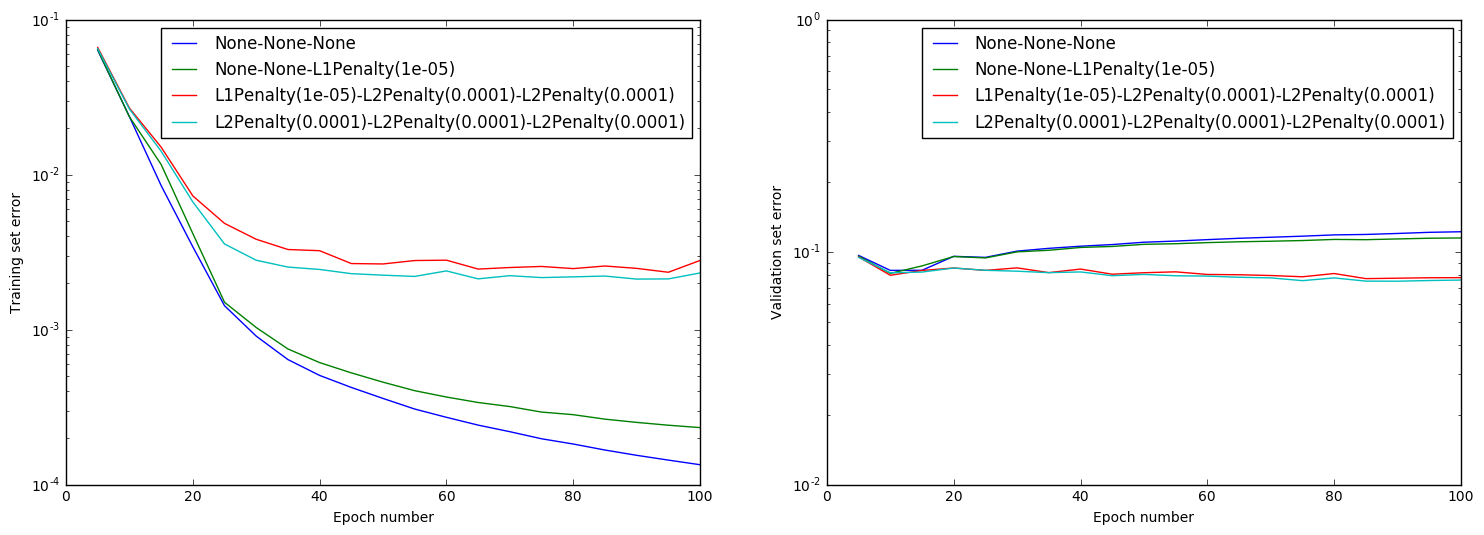

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('seaborn-talk')

# subdir = 'l1_l2_penalties'
# save_path = create_and_return_path(subdir, save_path_main)

# Unpickle all important objects
penalty_combos = pickle.load(open(os.path.join(save_path_main, subdir, "penalty_combos.p"), "rb"))
penalty_strs   = pickle.load(open(os.path.join(save_path_main, subdir, "penalty_strs.p"), "rb"))
run_info       = pickle.load(open(os.path.join(save_path_main, subdir, "run_info.p"), "rb"))
models         = pickle.load(open(os.path.join(save_path_main, subdir, "models.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
penalty_combos_to_plot_idx = [0, 1, 17, 26]

for i in xrange(len(penalty_combos)):
#     if penalty_combos[i] in penalty_combos_to_plot:
    if i in penalty_combos_to_plot_idx:
        stats, keys, run_time = run_info[i]
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=penalty_strs[i])
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=penalty_strs[i])
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'selected_penalties.pdf'))

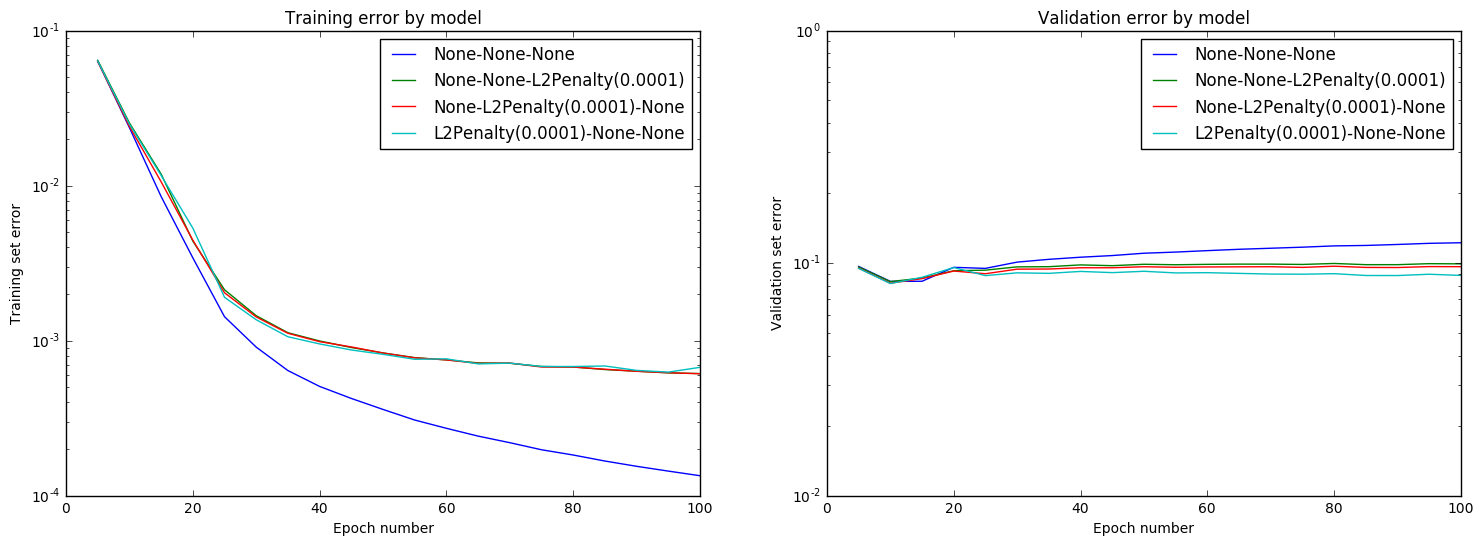

In [56]:
# Unpickle all important objects
penalty_combos = pickle.load(open(os.path.join(save_path_main, subdir, "penalty_combos.p"), "rb"))
penalty_strs   = pickle.load(open(os.path.join(save_path_main, subdir, "penalty_strs.p"), "rb"))
run_info       = pickle.load(open(os.path.join(save_path_main, subdir, "run_info.p"), "rb"))
models         = pickle.load(open(os.path.join(save_path_main, subdir, "models.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
penalty_combos_to_plot_idx = [0, 18, 6, 2]

for i in xrange(len(penalty_combos)):
#     if penalty_combos[i] in penalty_combos_to_plot:
    if i in penalty_combos_to_plot_idx:
        stats, keys, run_time = run_info[i]
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=penalty_strs[i])
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=penalty_strs[i])
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax1.set_title('Training error by model')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
ax2.set_title('Validation error by model')

plt.savefig(os.path.join(save_path, 'penalty_by_layer.pdf'))

In [89]:
# penalty_strs = []
# for weights_penalty1 in weights_penalties:
#     for weights_penalty2 in weights_penalties:
#         for weights_penalty3 in weights_penalties:
            
#             penalty_str = str(weights_penalty1) + '|' + str(weights_penalty2) + '|' + str(weights_penalty3)
#             penalty_strs.append(penalty_str)
# print penalty_strs

['None|None|None', 'None|None|L1Penalty(1e-05)', 'None|None|L2Penalty(0.0001)', 'None|L1Penalty(1e-05)|None', 'None|L1Penalty(1e-05)|L1Penalty(1e-05)', 'None|L1Penalty(1e-05)|L2Penalty(0.0001)', 'None|L2Penalty(0.0001)|None', 'None|L2Penalty(0.0001)|L1Penalty(1e-05)', 'None|L2Penalty(0.0001)|L2Penalty(0.0001)', 'L1Penalty(1e-05)|None|None', 'L1Penalty(1e-05)|None|L1Penalty(1e-05)', 'L1Penalty(1e-05)|None|L2Penalty(0.0001)', 'L1Penalty(1e-05)|L1Penalty(1e-05)|None', 'L1Penalty(1e-05)|L1Penalty(1e-05)|L1Penalty(1e-05)', 'L1Penalty(1e-05)|L1Penalty(1e-05)|L2Penalty(0.0001)', 'L1Penalty(1e-05)|L2Penalty(0.0001)|None', 'L1Penalty(1e-05)|L2Penalty(0.0001)|L1Penalty(1e-05)', 'L1Penalty(1e-05)|L2Penalty(0.0001)|L2Penalty(0.0001)', 'L2Penalty(0.0001)|None|None', 'L2Penalty(0.0001)|None|L1Penalty(1e-05)', 'L2Penalty(0.0001)|None|L2Penalty(0.0001)', 'L2Penalty(0.0001)|L1Penalty(1e-05)|None', 'L2Penalty(0.0001)|L1Penalty(1e-05)|L1Penalty(1e-05)', 'L2Penalty(0.0001)|L1Penalty(1e-05)|L2Penalty(0.000

In [94]:
import re  # for split

# Get ids for sorted val error
err_for_order = []
for i in xrange(len(penalty_strs)):
    stats, keys, run_time = run_info[i]
    err_for_order.append(stats[1:, keys['error(valid)']][-1])
ids = sorted(range(len(err_for_order)), key = lambda k: err_for_order[k])  # http://stackoverflow.com/a/7851166/4794432

# Print for LaTeX
print '\\begin{tabular}{lllr}'
print '\\hline'
for i in ids:
    stats, keys, run_time = run_info[i]
    print ' & '.join(re.split('\|', re.sub('Penalty[^\)]*\)', '', penalty_strs[i]))) + \
    ' & ' + \
    '{0:.4f}'.format(stats[1:, keys['error(valid)']][-1]) + \
    ' \\\\'
print '\\hline'
print '\\end{tabular}'

\begin{tabular}{lllr}
\hline
L2 & L2 & L2 & 0.0757 \\
L1 & L2 & L2 & 0.0776 \\
L1 & L2 & L1 & 0.0785 \\
L2 & L1 & L2 & 0.0795 \\
L2 & L2 & L1 & 0.0796 \\
L1 & L2 & None & 0.0805 \\
L1 & None & L2 & 0.0812 \\
L2 & None & L2 & 0.0820 \\
L2 & L1 & None & 0.0823 \\
L2 & L2 & None & 0.0823 \\
L1 & L1 & L1 & 0.0826 \\
L1 & L1 & L2 & 0.0836 \\
L1 & L1 & None & 0.0842 \\
L2 & L1 & L1 & 0.0843 \\
L2 & None & L1 & 0.0862 \\
None & L2 & L2 & 0.0865 \\
L2 & None & None & 0.0884 \\
L1 & None & None & 0.0901 \\
None & L1 & L2 & 0.0905 \\
None & L2 & L1 & 0.0917 \\
None & L2 & None & 0.0964 \\
None & None & L2 & 0.0992 \\
None & L1 & None & 0.1019 \\
None & L1 & L1 & 0.1027 \\
L1 & None & L1 & 0.1135 \\
None & None & L1 & 0.1149 \\
None & None & None & 0.1222 \\
\hline
\end{tabular}


# Data augmentation: Gaussian filter

Original rotation code from lab 5

In [243]:
from scipy.ndimage.interpolation import rotate

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

My code: Gaussian filter

In [244]:
from scipy.ndimage.filters import gaussian_filter

def random_gaussian_filter(inputs, rng, sigma_max = 1., prop_augmented = 0.25):
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], int(orig_ims.shape[0] * prop_augmented), False)
    sigmas = rng.uniform(0., sigma_max, size=indices.shape[0])
    for i, j in enumerate(indices):
        new_ims[j] = gaussian_filter(orig_ims[j], sigmas[i])
    return new_ims.reshape((-1, 784))

In [245]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'gaussian_filter'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

path created: run/coursework2/gaussian_filter/2016-11-23
deleting files in: run/coursework2/gaussian_filter/2016-11-23


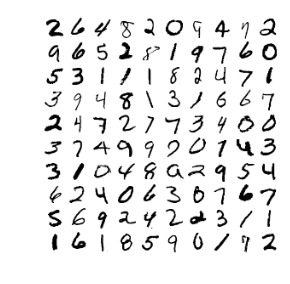

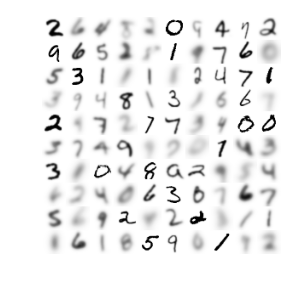

In [246]:
def show_batch_of_images(img_batch, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()

fig1, ax1 = show_batch_of_images(inputs.reshape((-1, 28, 28)))
# plt.savefig(os.path.join(save_path, 'orig_img.pdf'))

transformed_inputs = random_gaussian_filter(inputs, rng, 4, 1.)
fig2, ax2 = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))
# plt.savefig(os.path.join(save_path, 'aug_img.pdf'))


# Plot stuff
# fig = plt.figure(figsize=(18, 6))
# fig1 = fig.add_subplot(1, 2, 1)
# plt.imshow(fig1)


# for i in xrange(len(penalty_combos)):
# #     if penalty_combos[i] in penalty_combos_to_plot:
#     if i in penalty_combos_to_plot_idx:
#         stats, keys, run_time = run_info[i]
#         ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#                  stats[1:, keys['error(train)']], label=penalty_strs[i])
#         ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#                  stats[1:, keys['error(valid)']], label=penalty_strs[i])
# ax1.legend(loc=0)
# ax1.set_xlabel('Epoch number')
# ax1.set_ylabel('Training set error')
# ax1.set_yscale('log')
# ax1.set_title('Training error by model')
# ax2.legend(loc=0)
# ax2.set_xlabel('Epoch number')
# ax2.set_ylabel('Validation set error')
# ax2.set_yscale('log')

Train model.

In [263]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'gaussian_filter'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

path created: run/coursework2/gaussian_filter/2016-11-23
deleting files in: run/coursework2/gaussian_filter/2016-11-23


In [264]:
from mlp.data_providers import AugmentedMNISTDataProvider  # *********

import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

sigma max = 0, proportion augmented = 0


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 1.41s to complete
  error(train)=1.96e-01, acc(train)=9.43e-01, error(valid)=1.89e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 10: 1.37s to complete
  error(train)=1.09e-01, acc(train)=9.69e-01, error(valid)=1.25e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 1.31s to complete
  error(train)=7.47e-02, acc(train)=9.79e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 1.33s to complete
  error(train)=5.24e-02, acc(train)=9.86e-01, error(valid)=9.43e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 1.43s to complete
  error(train)=3.71e-02, acc(train)=9.91e-01, error(valid)=8.71e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 1.49s to complete
  error(train)=2.69e-02, acc(train)=9.94e-01, error(valid)=8.40e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 1.47s to complet

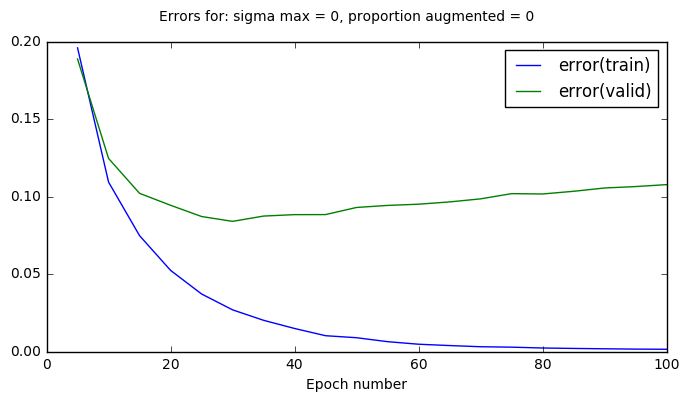

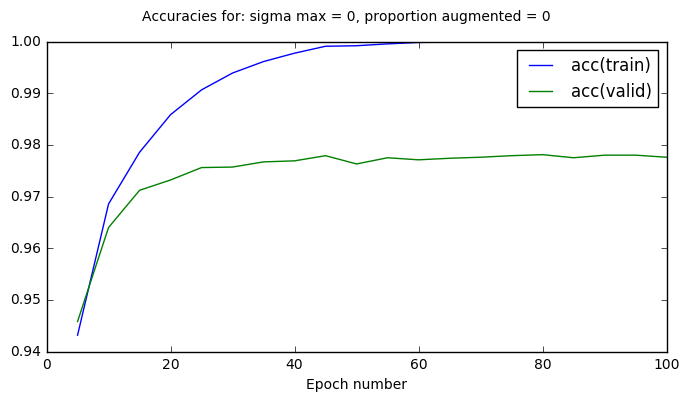

sigma max = 0, proportion augmented = 0.17
skipping...
sigma max = 0, proportion augmented = 0.25
skipping...
sigma max = 0, proportion augmented = 0.33
skipping...
sigma max = 0, proportion augmented = 0.5
skipping...
sigma max = 0.5, proportion augmented = 0
skipping...
sigma max = 0.5, proportion augmented = 0.17


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 1.85s to complete
  error(train)=1.95e-01, acc(train)=9.45e-01, error(valid)=1.86e-01, acc(valid)=9.48e-01, params_penalty=0.00e+00
Epoch 10: 1.86s to complete
  error(train)=1.11e-01, acc(train)=9.68e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 1.88s to complete
  error(train)=7.57e-02, acc(train)=9.79e-01, error(valid)=1.03e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 20: 1.96s to complete
  error(train)=5.07e-02, acc(train)=9.87e-01, error(valid)=9.01e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 1.87s to complete
  error(train)=3.86e-02, acc(train)=9.90e-01, error(valid)=8.54e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 1.93s to complete
  error(train)=2.63e-02, acc(train)=9.94e-01, error(valid)=8.41e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 1.87s to complet

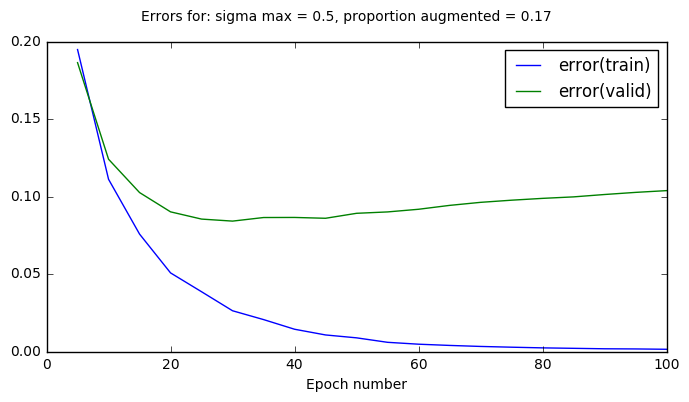

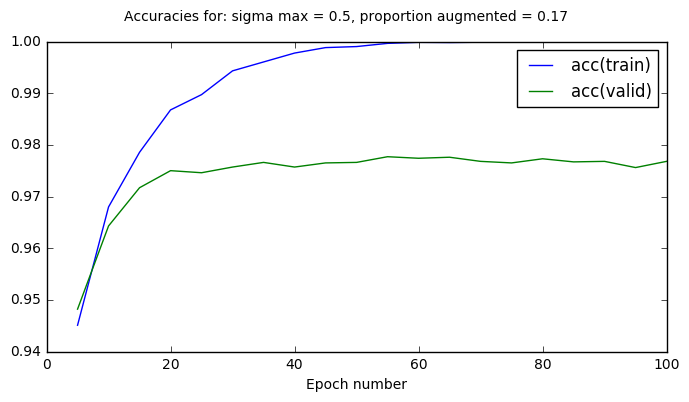

sigma max = 0.5, proportion augmented = 0.25


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.81e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.24s to complete
  error(train)=1.91e-01, acc(train)=9.45e-01, error(valid)=1.85e-01, acc(valid)=9.48e-01, params_penalty=0.00e+00
Epoch 10: 2.12s to complete
  error(train)=1.09e-01, acc(train)=9.69e-01, error(valid)=1.23e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 15: 2.11s to complete
  error(train)=7.19e-02, acc(train)=9.80e-01, error(valid)=9.94e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 20: 2.16s to complete
  error(train)=5.21e-02, acc(train)=9.86e-01, error(valid)=8.83e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 2.13s to complete
  error(train)=3.70e-02, acc(train)=9.90e-01, error(valid)=8.74e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 2.17s to complete
  error(train)=2.57e-02, acc(train)=9.94e-01, error(valid)=8.31e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 2.10s to complet

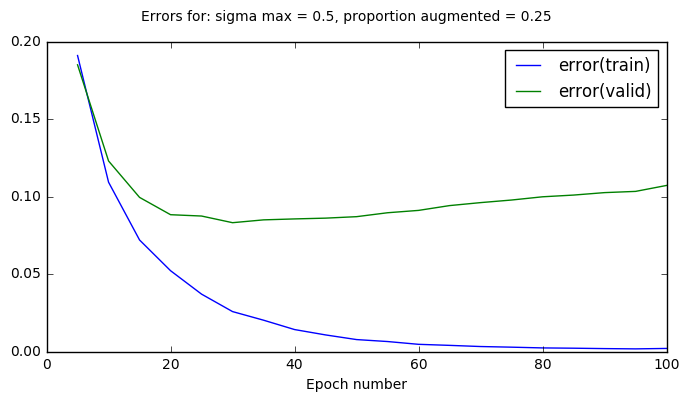

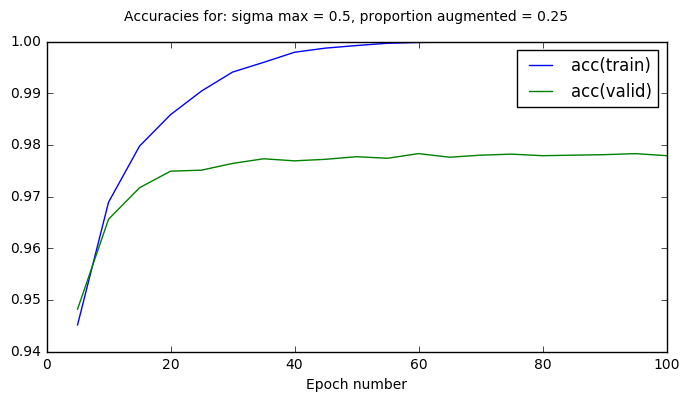

sigma max = 0.5, proportion augmented = 0.33


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.81e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.39s to complete
  error(train)=1.96e-01, acc(train)=9.45e-01, error(valid)=1.88e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 10: 2.39s to complete
  error(train)=1.12e-01, acc(train)=9.68e-01, error(valid)=1.27e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.50s to complete
  error(train)=8.07e-02, acc(train)=9.77e-01, error(valid)=1.09e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 2.40s to complete
  error(train)=5.14e-02, acc(train)=9.86e-01, error(valid)=8.74e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 2.48s to complete
  error(train)=3.79e-02, acc(train)=9.91e-01, error(valid)=8.50e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 2.38s to complete
  error(train)=2.71e-02, acc(train)=9.94e-01, error(valid)=7.98e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 2.51s to complet

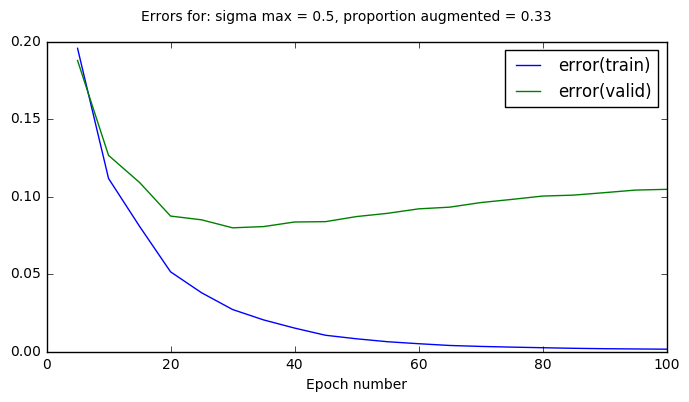

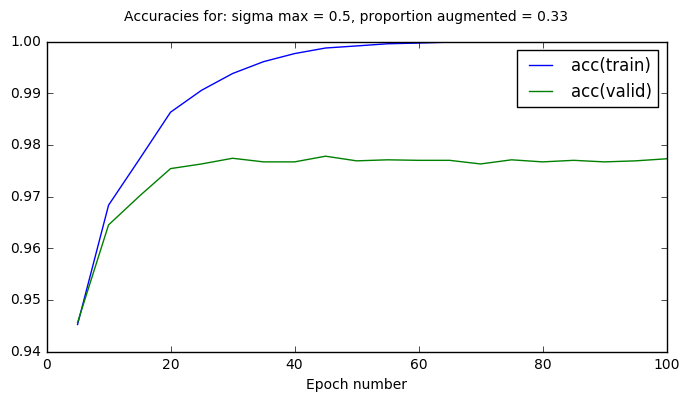

sigma max = 0.5, proportion augmented = 0.5


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.81e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.10s to complete
  error(train)=2.01e-01, acc(train)=9.43e-01, error(valid)=1.94e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 10: 5.55s to complete
  error(train)=1.16e-01, acc(train)=9.66e-01, error(valid)=1.28e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 15: 2.96s to complete
  error(train)=7.40e-02, acc(train)=9.79e-01, error(valid)=1.00e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 20: 3.02s to complete
  error(train)=5.85e-02, acc(train)=9.83e-01, error(valid)=9.95e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 2.86s to complete
  error(train)=3.74e-02, acc(train)=9.90e-01, error(valid)=8.33e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 30: 2.97s to complete
  error(train)=3.16e-02, acc(train)=9.92e-01, error(valid)=9.01e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 2.89s to complet

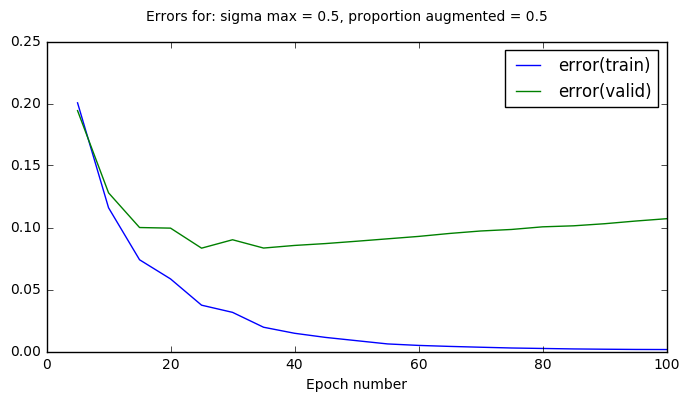

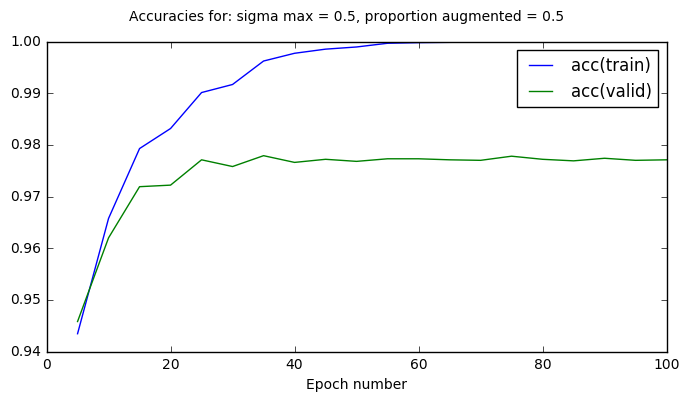

sigma max = 1, proportion augmented = 0
skipping...
sigma max = 1, proportion augmented = 0.17


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.84e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.25s to complete
  error(train)=1.97e-01, acc(train)=9.45e-01, error(valid)=1.86e-01, acc(valid)=9.48e-01, params_penalty=0.00e+00
Epoch 10: 2.79s to complete
  error(train)=1.13e-01, acc(train)=9.67e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.09s to complete
  error(train)=7.78e-02, acc(train)=9.78e-01, error(valid)=1.03e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.11s to complete
  error(train)=5.39e-02, acc(train)=9.85e-01, error(valid)=9.03e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 25: 2.13s to complete
  error(train)=4.18e-02, acc(train)=9.88e-01, error(valid)=8.52e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 30: 2.43s to complete
  error(train)=2.90e-02, acc(train)=9.93e-01, error(valid)=8.26e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 2.00s to complet

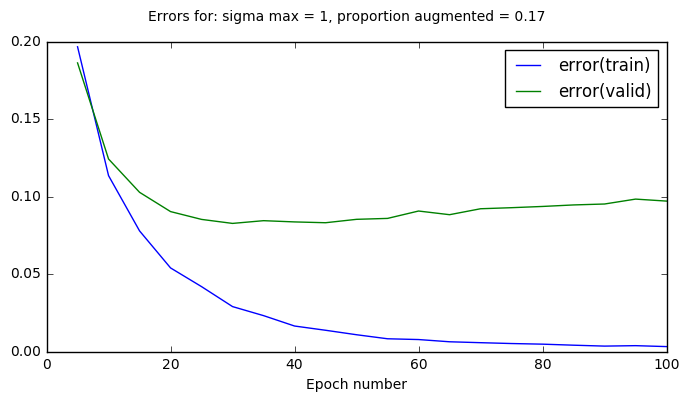

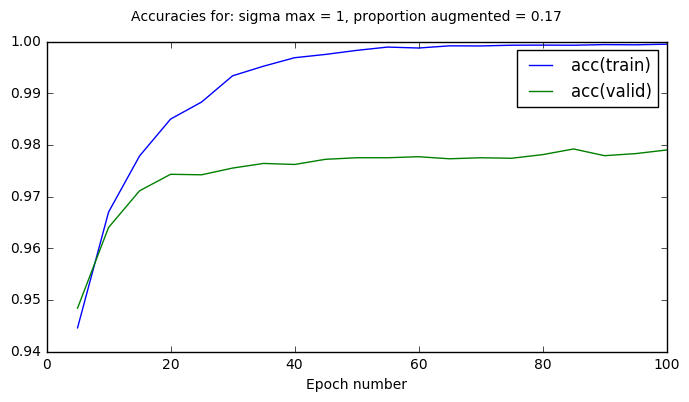

sigma max = 1, proportion augmented = 0.25


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.84e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.84s to complete
  error(train)=1.93e-01, acc(train)=9.44e-01, error(valid)=1.85e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 10: 2.85s to complete
  error(train)=1.12e-01, acc(train)=9.68e-01, error(valid)=1.23e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 15: 2.21s to complete
  error(train)=7.56e-02, acc(train)=9.78e-01, error(valid)=1.00e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.30s to complete
  error(train)=5.53e-02, acc(train)=9.85e-01, error(valid)=8.78e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 2.82s to complete
  error(train)=4.17e-02, acc(train)=9.89e-01, error(valid)=8.73e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 3.13s to complete
  error(train)=2.96e-02, acc(train)=9.92e-01, error(valid)=8.22e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 2.29s to complet

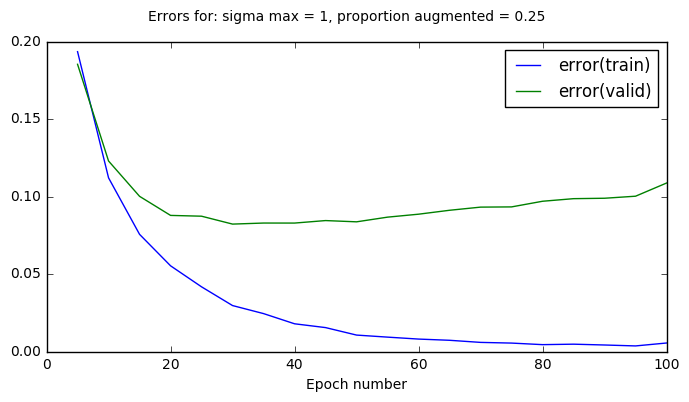

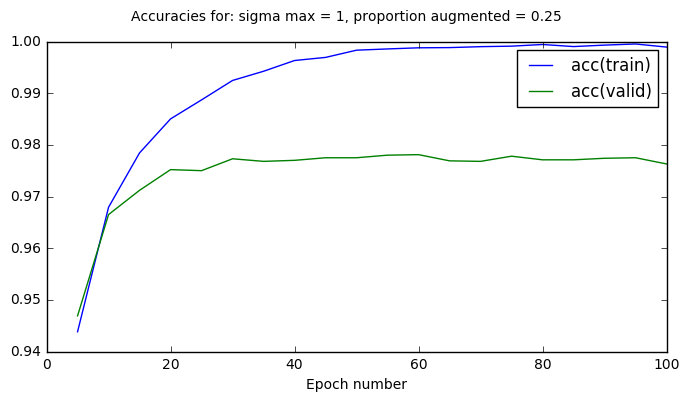

sigma max = 1, proportion augmented = 0.33


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.83e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.55s to complete
  error(train)=1.99e-01, acc(train)=9.44e-01, error(valid)=1.88e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 10: 2.73s to complete
  error(train)=1.16e-01, acc(train)=9.67e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.64s to complete
  error(train)=8.49e-02, acc(train)=9.76e-01, error(valid)=1.08e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 2.77s to complete
  error(train)=5.69e-02, acc(train)=9.84e-01, error(valid)=8.74e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 25: 2.50s to complete
  error(train)=4.24e-02, acc(train)=9.88e-01, error(valid)=8.37e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 30: 3.21s to complete
  error(train)=3.16e-02, acc(train)=9.92e-01, error(valid)=7.75e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 2.87s to complet

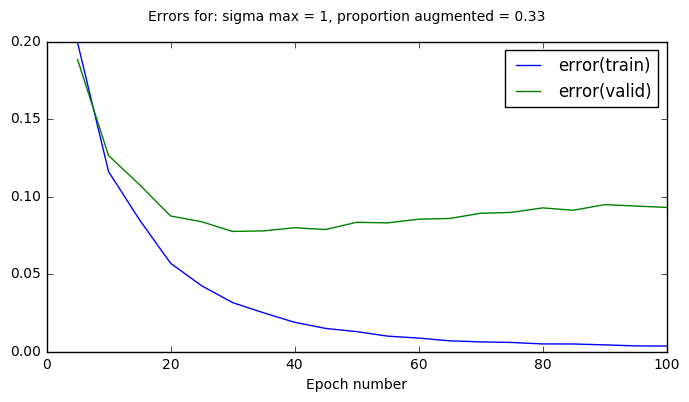

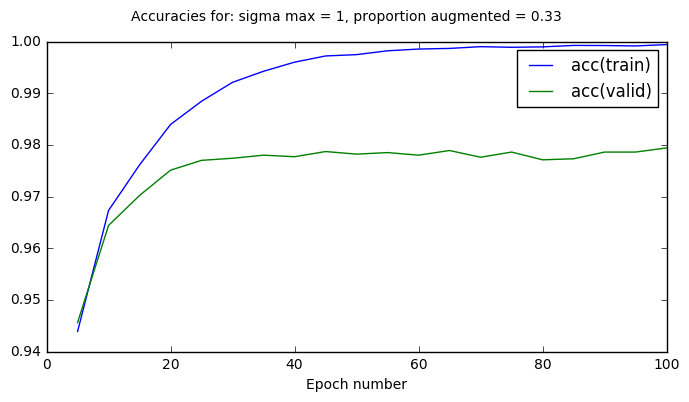

sigma max = 1, proportion augmented = 0.5


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.83e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.99s to complete
  error(train)=2.08e-01, acc(train)=9.41e-01, error(valid)=1.95e-01, acc(valid)=9.45e-01, params_penalty=0.00e+00
Epoch 10: 4.66s to complete
  error(train)=1.22e-01, acc(train)=9.64e-01, error(valid)=1.29e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 15: 4.27s to complete
  error(train)=8.02e-02, acc(train)=9.77e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 6.92s to complete
  error(train)=6.51e-02, acc(train)=9.81e-01, error(valid)=9.78e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 4.58s to complete
  error(train)=4.40e-02, acc(train)=9.88e-01, error(valid)=8.23e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 30: 4.23s to complete
  error(train)=3.84e-02, acc(train)=9.89e-01, error(valid)=8.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 5.82s to complet

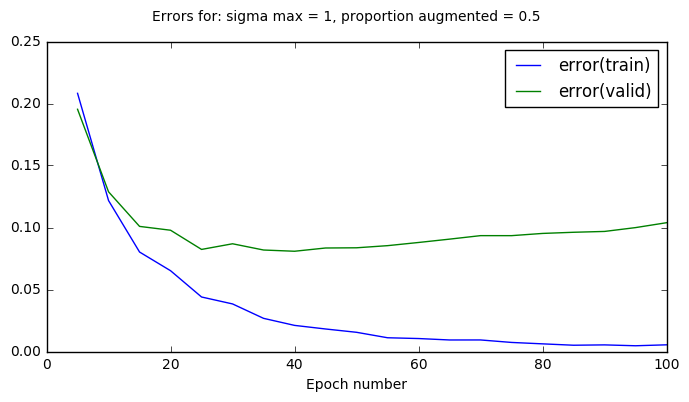

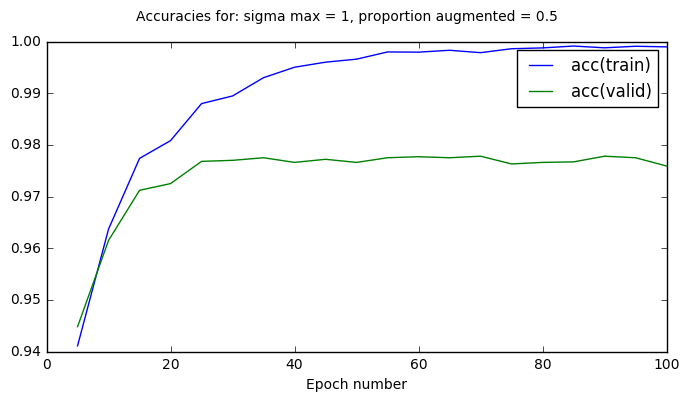

sigma max = 2, proportion augmented = 0
skipping...
sigma max = 2, proportion augmented = 0.17


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.83e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.14s to complete
  error(train)=2.05e-01, acc(train)=9.43e-01, error(valid)=1.85e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 10: 2.44s to complete
  error(train)=1.23e-01, acc(train)=9.64e-01, error(valid)=1.25e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.86s to complete
  error(train)=8.63e-02, acc(train)=9.75e-01, error(valid)=1.05e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.14s to complete
  error(train)=6.16e-02, acc(train)=9.83e-01, error(valid)=9.33e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 25: 2.53s to complete
  error(train)=4.98e-02, acc(train)=9.86e-01, error(valid)=8.87e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.09s to complete
  error(train)=3.58e-02, acc(train)=9.91e-01, error(valid)=8.50e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 2.10s to complet

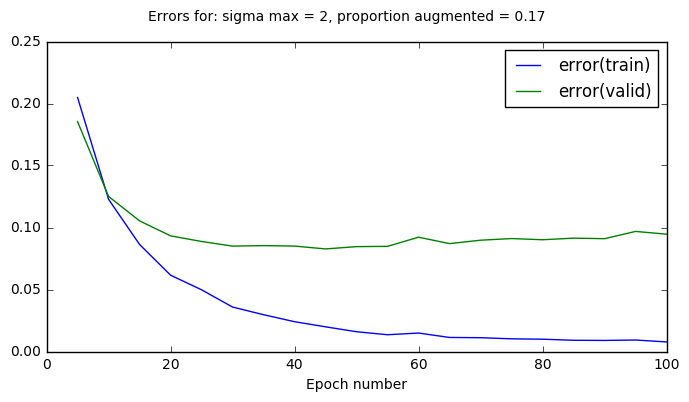

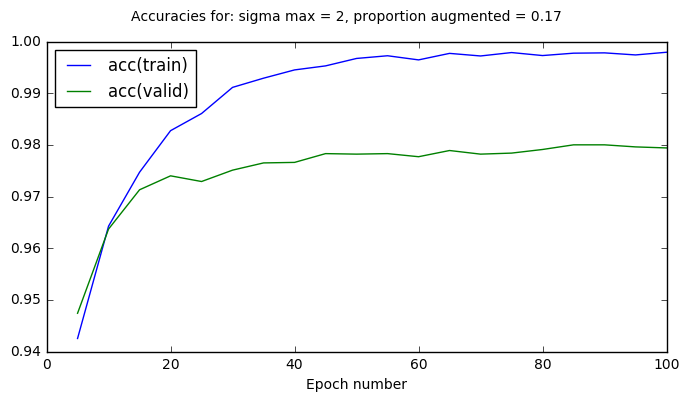

sigma max = 2, proportion augmented = 0.25


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.89e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.48s to complete
  error(train)=2.04e-01, acc(train)=9.41e-01, error(valid)=1.86e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 10: 2.73s to complete
  error(train)=1.23e-01, acc(train)=9.64e-01, error(valid)=1.24e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.62s to complete
  error(train)=8.72e-02, acc(train)=9.75e-01, error(valid)=1.03e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 3.35s to complete
  error(train)=6.69e-02, acc(train)=9.81e-01, error(valid)=9.23e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 25: 2.76s to complete
  error(train)=5.12e-02, acc(train)=9.85e-01, error(valid)=8.87e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 2.70s to complete
  error(train)=3.93e-02, acc(train)=9.90e-01, error(valid)=8.44e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 3.16s to complet

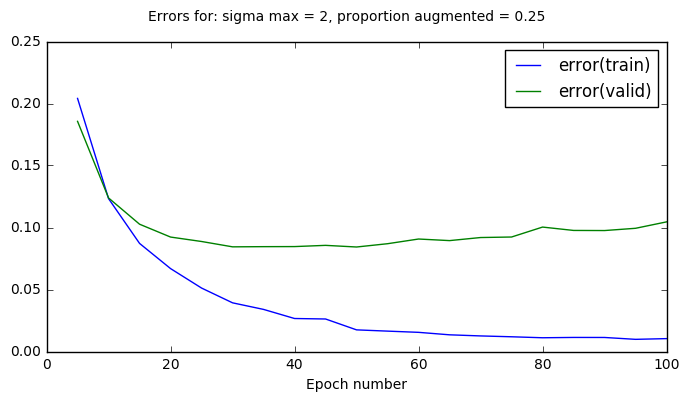

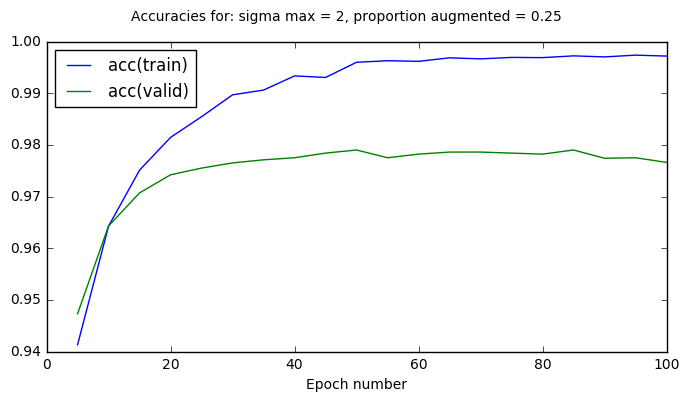

sigma max = 2, proportion augmented = 0.33


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.82e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.59s to complete
  error(train)=2.16e-01, acc(train)=9.39e-01, error(valid)=1.91e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 10: 2.79s to complete
  error(train)=1.32e-01, acc(train)=9.62e-01, error(valid)=1.29e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.70s to complete
  error(train)=9.63e-02, acc(train)=9.72e-01, error(valid)=1.09e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 2.87s to complete
  error(train)=7.08e-02, acc(train)=9.79e-01, error(valid)=9.16e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 2.78s to complete
  error(train)=5.49e-02, acc(train)=9.85e-01, error(valid)=8.78e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 2.71s to complete
  error(train)=4.37e-02, acc(train)=9.88e-01, error(valid)=8.17e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 2.72s to complet

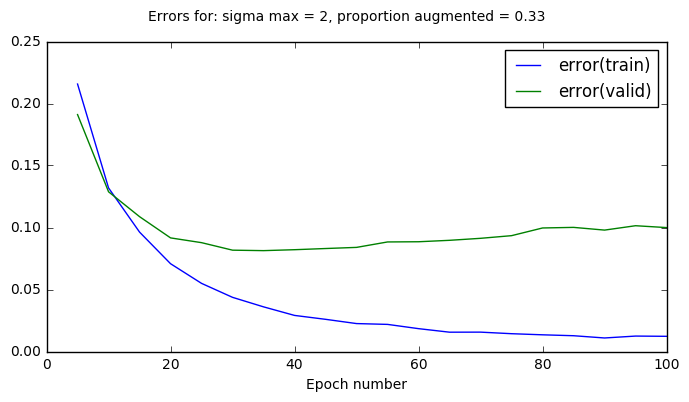

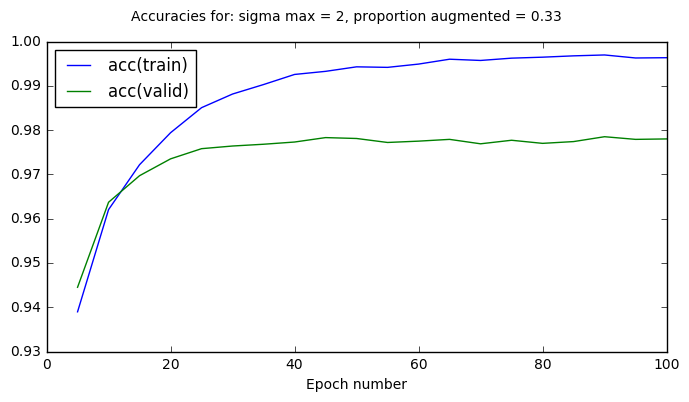

sigma max = 2, proportion augmented = 0.5


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.85e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.65s to complete
  error(train)=2.29e-01, acc(train)=9.34e-01, error(valid)=1.95e-01, acc(valid)=9.43e-01, params_penalty=0.00e+00
Epoch 10: 4.35s to complete
  error(train)=1.41e-01, acc(train)=9.58e-01, error(valid)=1.33e-01, acc(valid)=9.60e-01, params_penalty=0.00e+00
Epoch 15: 4.28s to complete
  error(train)=9.96e-02, acc(train)=9.71e-01, error(valid)=1.07e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 20: 4.04s to complete
  error(train)=8.14e-02, acc(train)=9.75e-01, error(valid)=1.00e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 3.50s to complete
  error(train)=6.12e-02, acc(train)=9.82e-01, error(valid)=8.86e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 30: 3.35s to complete
  error(train)=5.56e-02, acc(train)=9.83e-01, error(valid)=9.36e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 4.30s to complet

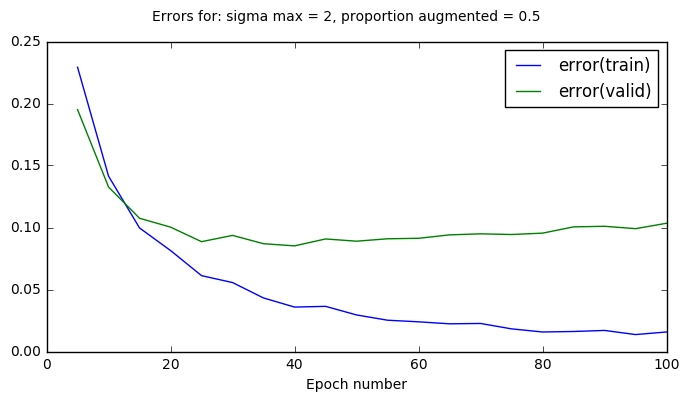

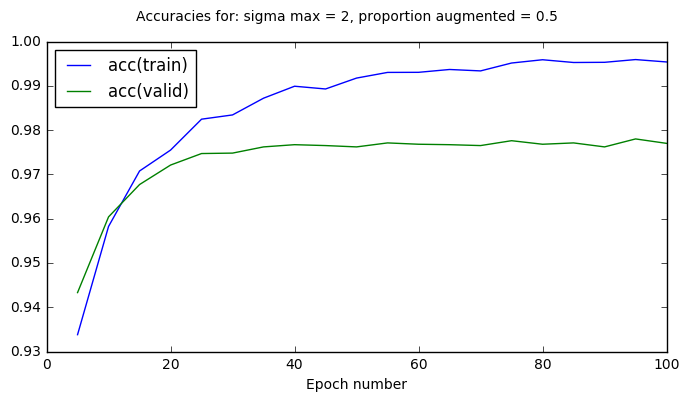

sigma max = 4, proportion augmented = 0
skipping...
sigma max = 4, proportion augmented = 0.17


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.78e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 4.22s to complete
  error(train)=2.39e-01, acc(train)=9.33e-01, error(valid)=1.88e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 10: 2.21s to complete
  error(train)=1.53e-01, acc(train)=9.56e-01, error(valid)=1.28e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 15: 2.23s to complete
  error(train)=1.12e-01, acc(train)=9.67e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 2.92s to complete
  error(train)=8.65e-02, acc(train)=9.74e-01, error(valid)=9.85e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 2.67s to complete
  error(train)=6.95e-02, acc(train)=9.80e-01, error(valid)=9.31e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.43s to complete
  error(train)=5.55e-02, acc(train)=9.84e-01, error(valid)=9.02e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 2.27s to complet

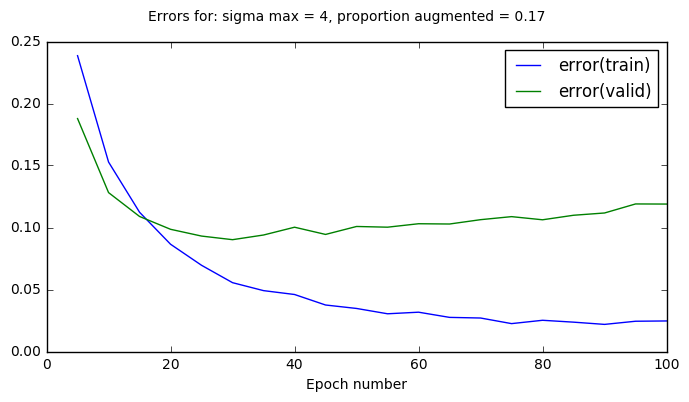

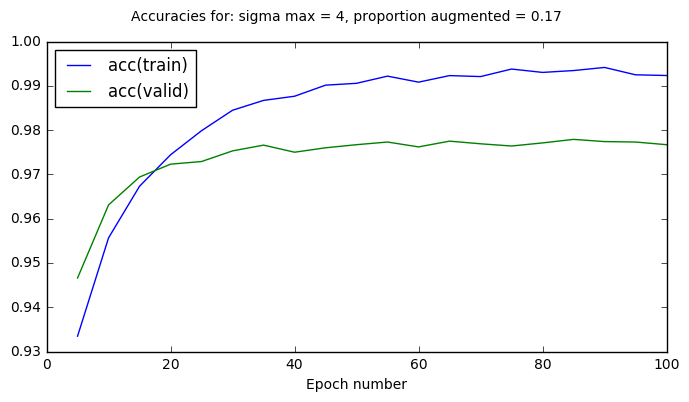

sigma max = 4, proportion augmented = 0.25


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.86e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.98s to complete
  error(train)=2.50e-01, acc(train)=9.30e-01, error(valid)=1.89e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 10: 2.78s to complete
  error(train)=1.62e-01, acc(train)=9.54e-01, error(valid)=1.30e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 15: 2.78s to complete
  error(train)=1.22e-01, acc(train)=9.65e-01, error(valid)=1.10e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 2.83s to complete
  error(train)=1.03e-01, acc(train)=9.70e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 2.78s to complete
  error(train)=8.10e-02, acc(train)=9.77e-01, error(valid)=9.77e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 30: 2.87s to complete
  error(train)=6.81e-02, acc(train)=9.81e-01, error(valid)=9.64e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 35: 2.91s to complet

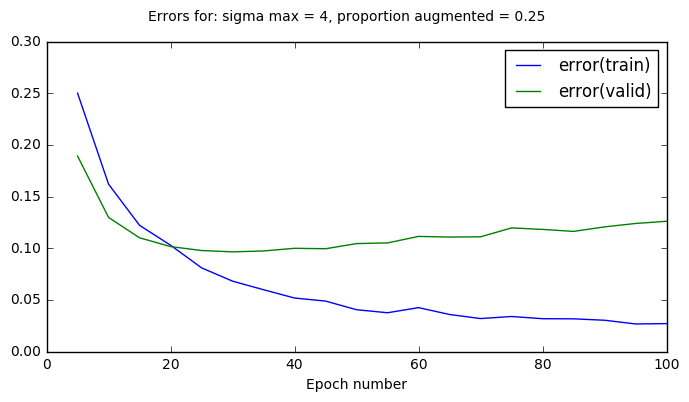

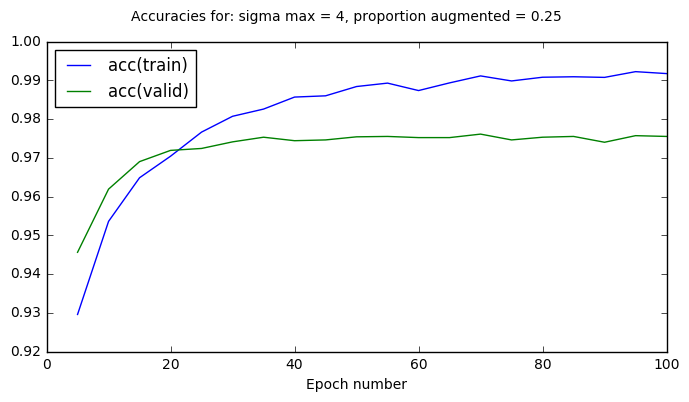

sigma max = 4, proportion augmented = 0.33


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.84e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.93s to complete
  error(train)=2.73e-01, acc(train)=9.24e-01, error(valid)=1.96e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 10: 3.17s to complete
  error(train)=1.83e-01, acc(train)=9.47e-01, error(valid)=1.38e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 15: 3.60s to complete
  error(train)=1.41e-01, acc(train)=9.59e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 20: 4.10s to complete
  error(train)=1.16e-01, acc(train)=9.65e-01, error(valid)=1.04e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 25: 3.13s to complete
  error(train)=9.33e-02, acc(train)=9.73e-01, error(valid)=9.94e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 3.17s to complete
  error(train)=8.02e-02, acc(train)=9.76e-01, error(valid)=9.56e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 35: 3.14s to complet

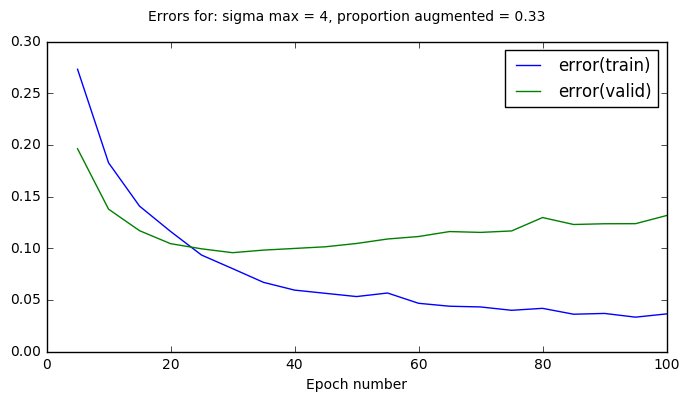

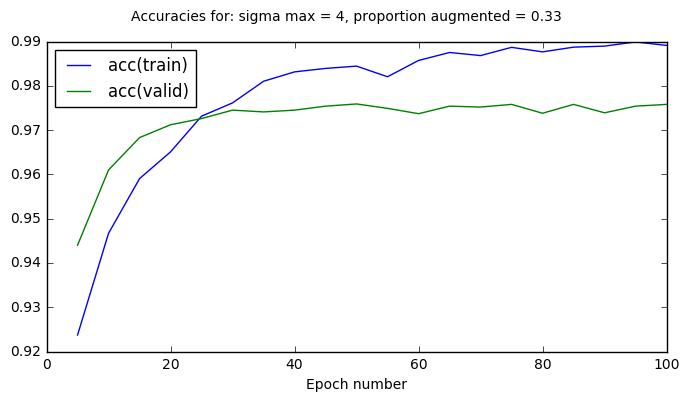

sigma max = 4, proportion augmented = 0.5


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.82e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.86s to complete
  error(train)=3.10e-01, acc(train)=9.10e-01, error(valid)=2.07e-01, acc(valid)=9.42e-01, params_penalty=0.00e+00
Epoch 10: 3.76s to complete
  error(train)=2.05e-01, acc(train)=9.41e-01, error(valid)=1.44e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 15: 3.81s to complete
  error(train)=1.59e-01, acc(train)=9.54e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 20: 4.91s to complete
  error(train)=1.41e-01, acc(train)=9.58e-01, error(valid)=1.15e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 25: 4.38s to complete
  error(train)=1.19e-01, acc(train)=9.63e-01, error(valid)=1.12e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 30: 4.55s to complete
  error(train)=1.00e-01, acc(train)=9.70e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 7.19s to complet

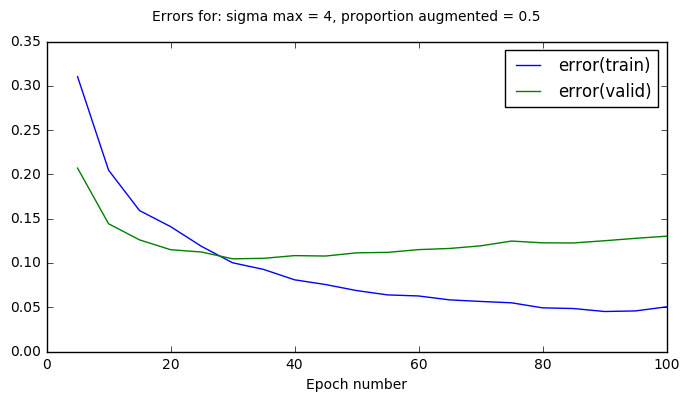

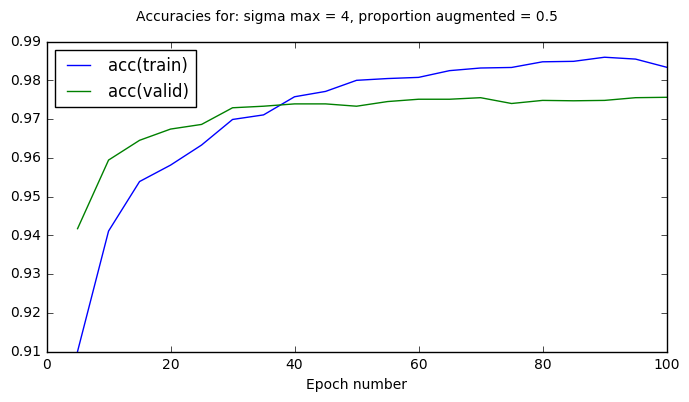

sigma max = 8, proportion augmented = 0
skipping...
sigma max = 8, proportion augmented = 0.17


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.88e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.57s to complete
  error(train)=3.30e-01, acc(train)=9.04e-01, error(valid)=1.92e-01, acc(valid)=9.45e-01, params_penalty=0.00e+00
Epoch 10: 2.58s to complete
  error(train)=2.37e-01, acc(train)=9.27e-01, error(valid)=1.33e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 15: 2.56s to complete
  error(train)=1.89e-01, acc(train)=9.42e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 2.88s to complete
  error(train)=1.56e-01, acc(train)=9.53e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 25: 2.65s to complete
  error(train)=1.38e-01, acc(train)=9.55e-01, error(valid)=9.85e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.60s to complete
  error(train)=1.22e-01, acc(train)=9.63e-01, error(valid)=9.85e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 35: 2.53s to complet

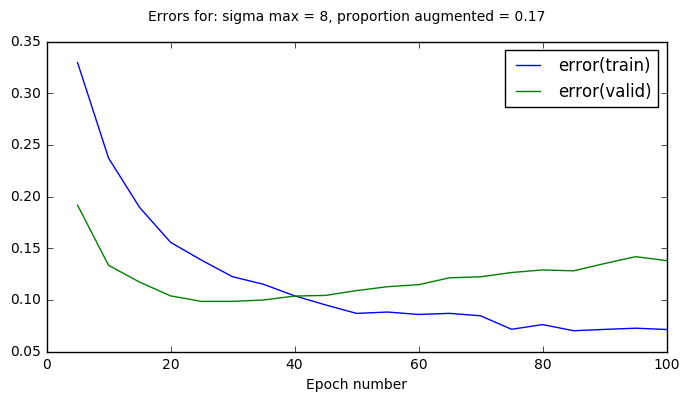

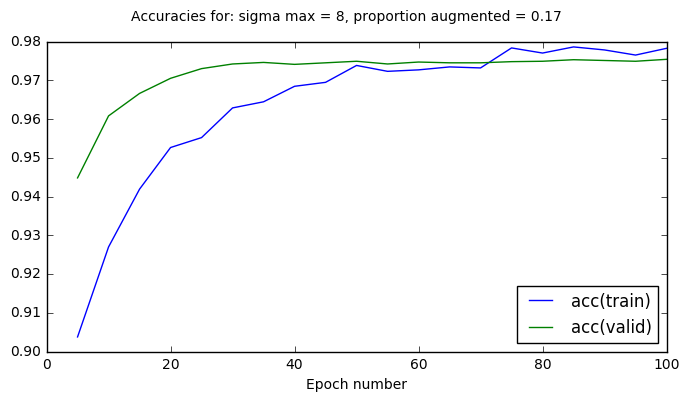

sigma max = 8, proportion augmented = 0.25


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.00e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.16s to complete
  error(train)=3.80e-01, acc(train)=8.85e-01, error(valid)=1.96e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 10: 3.14s to complete
  error(train)=2.82e-01, acc(train)=9.12e-01, error(valid)=1.38e-01, acc(valid)=9.59e-01, params_penalty=0.00e+00
Epoch 15: 3.17s to complete
  error(train)=2.29e-01, acc(train)=9.28e-01, error(valid)=1.18e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 20: 3.27s to complete
  error(train)=1.94e-01, acc(train)=9.41e-01, error(valid)=1.05e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 25: 3.26s to complete
  error(train)=1.71e-01, acc(train)=9.49e-01, error(valid)=1.04e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 30: 3.25s to complete
  error(train)=1.59e-01, acc(train)=9.48e-01, error(valid)=1.07e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 3.32s to complet

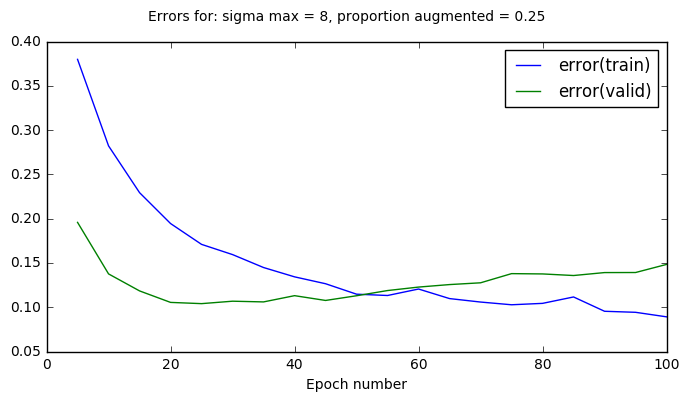

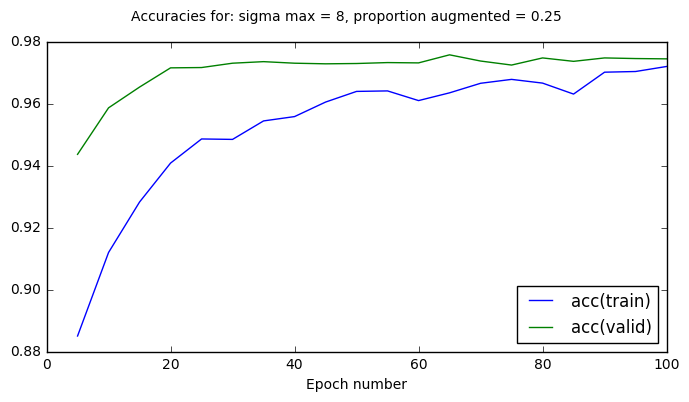

sigma max = 8, proportion augmented = 0.33


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.97e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 3.81s to complete
  error(train)=4.33e-01, acc(train)=8.73e-01, error(valid)=2.05e-01, acc(valid)=9.40e-01, params_penalty=0.00e+00
Epoch 10: 4.09s to complete
  error(train)=3.28e-01, acc(train)=8.96e-01, error(valid)=1.48e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 15: 4.09s to complete
  error(train)=2.75e-01, acc(train)=9.15e-01, error(valid)=1.22e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 20: 4.19s to complete
  error(train)=2.34e-01, acc(train)=9.27e-01, error(valid)=1.10e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 25: 4.56s to complete
  error(train)=2.19e-01, acc(train)=9.29e-01, error(valid)=1.09e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 30: 3.97s to complete
  error(train)=1.85e-01, acc(train)=9.43e-01, error(valid)=1.05e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 4.61s to complet

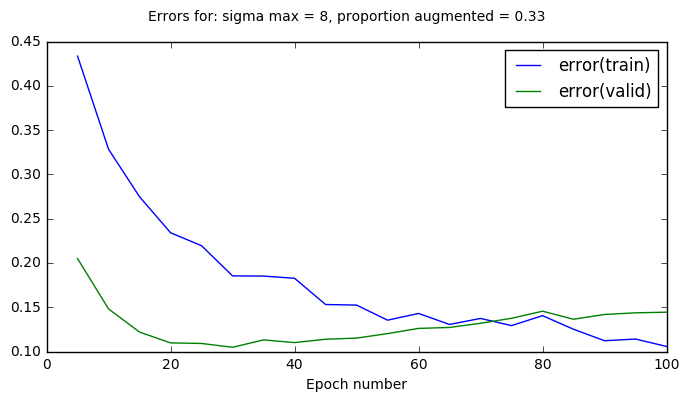

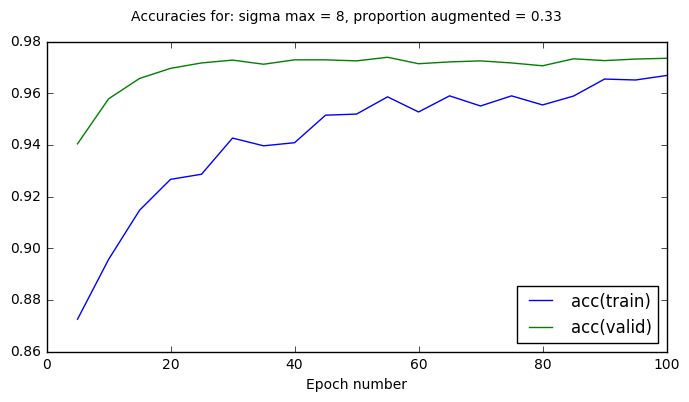

sigma max = 8, proportion augmented = 0.5


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.00e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 5.20s to complete
  error(train)=5.34e-01, acc(train)=8.34e-01, error(valid)=2.24e-01, acc(valid)=9.36e-01, params_penalty=0.00e+00
Epoch 10: 5.52s to complete
  error(train)=3.98e-01, acc(train)=8.73e-01, error(valid)=1.57e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00
Epoch 15: 5.67s to complete
  error(train)=3.31e-01, acc(train)=9.00e-01, error(valid)=1.37e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 20: 5.47s to complete
  error(train)=2.98e-01, acc(train)=9.07e-01, error(valid)=1.27e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 25: 6.21s to complete
  error(train)=2.62e-01, acc(train)=9.18e-01, error(valid)=1.17e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 30: 5.12s to complete
  error(train)=2.40e-01, acc(train)=9.24e-01, error(valid)=1.18e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 5.13s to complet

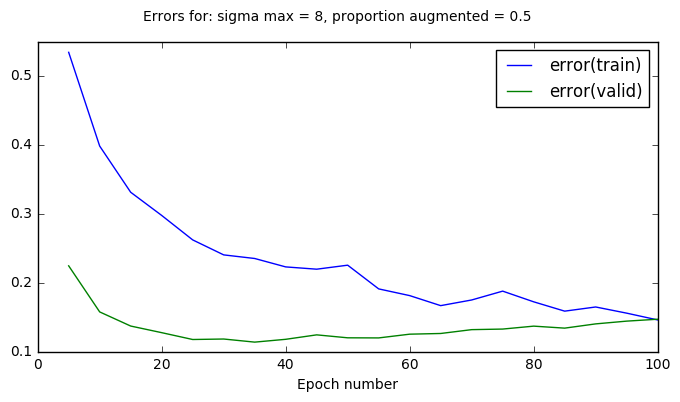

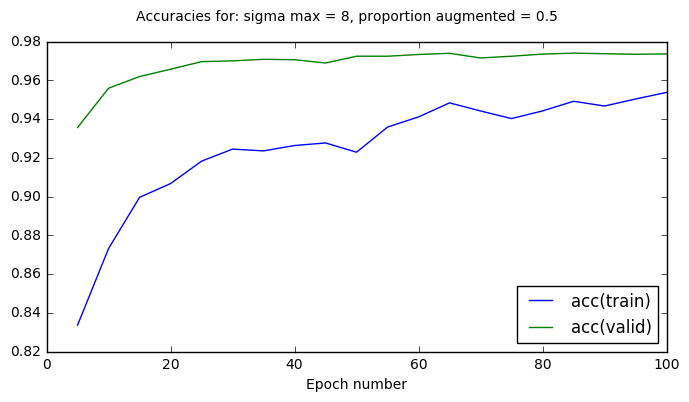

In [269]:
batch_size = 100
num_epochs = 100
learning_rate = 0.005
mom_coeff = 0.9
stats_interval = 5

# Set values to iterate over.
sigma_max_list = [0., 0.5, 1., 2., 4., 8.]
prop_augmented_list = [0., 0.17, 0.25, 0.33, 0.5]
# sigma_max_list = [0., 1., 2.]
# prop_augmented_list = [0., 0.17, 0.25]

# Initialize.
run_infos = OrderedDict()
    
for sigma_max in sigma_max_list:
    for prop_augmented in prop_augmented_list:
        
        hyperparam_str = 'sigma_max_{0:.2g}_prop_aug_{1:.2g}'.format(sigma_max, prop_augmented)
        hyperparam_str_pretty = 'sigma max = {0:.2g}, proportion augmented = {1:.2g}'.format(sigma_max, prop_augmented)
        print hyperparam_str_pretty
        
        
        if (sigma_max == 0. and prop_augmented > 0.) or (sigma_max > 0. and prop_augmented == 0.):
            print 'skipping...'
            run_infos[(sigma_max, prop_augmented)] = None
            continue
        
        def random_gaussian_filter_MNIST(inputs, rng):
            return random_gaussian_filter(inputs, rng, sigma_max, prop_augmented)
        
        aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_gaussian_filter_MNIST)
        
        rng.seed(seed)
        aug_train_data.reset()
        valid_data.reset()
        aug_train_data.batch_size = batch_size 
        valid_data.batch_size = batch_size

        weights_init = GlorotUniformInit(0.5, rng=rng)
        biases_init = ConstantInit(0.)

        model = MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
            ReluLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
        ])
        
        error = CrossEntropySoftmaxError()
        learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
        data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
        
        optimiser = Optimiser(
            model, error, learning_rule, aug_train_data, valid_data, data_monitors)
        run_info = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        
        stats, keys, run_time = run_info
        
        # Plot the change in the validation and training set error over training.
        fig_1 = plt.figure(figsize=(8, 4))
        ax_1 = fig_1.add_subplot(111)
        for k in ['error(train)', 'error(valid)']:
            ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, keys[k]], label=k)
        ax_1.legend(loc=0)
        ax_1.set_xlabel('Epoch number')
        fig_1.suptitle('Errors for: ' + hyperparam_str_pretty)

        plt.savefig(os.path.join(save_path, 'error_' + hyperparam_str + '.pdf'))

        # Plot the change in the validation and training set accuracy over training.
        fig_2 = plt.figure(figsize=(8, 4))
        ax_2 = fig_2.add_subplot(111)
        for k in ['acc(train)', 'acc(valid)']:
            ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                      stats[1:, keys[k]], label=k)
        ax_2.legend(loc=0)
        ax_2.set_xlabel('Epoch number')
        fig_2.suptitle('Accuracies for: ' + hyperparam_str_pretty)

        plt.savefig(os.path.join(save_path, 'acc_' + hyperparam_str + '.pdf'))
        plt.show()
        
        run_infos[(sigma_max, prop_augmented)] = run_info
        
        
# Pickle all important objects
pickle.dump(run_infos, open(os.path.join(save_path_main, subdir, "run_infos.p"), "wb"))

In [270]:
error_keys = []
error_values = []
for key, value in run_infos.iteritems():
    if value is None:
        continue
    error_keys.append(key)
    stats, keys, run_time = value
    error_values.append(stats[:, keys['error(valid)']][-1])

# Print values to paste into Excel pivot table
print 'Sigma max'
for error_key in error_keys:
    print error_key[0]

print ''
print 'Proportion augmented'
for error_key in error_keys:
    print error_key[1]

print ''
print 'Validation error values'  
for error_value in error_values:
    print error_value

Sigma max
0.0
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
4.0
4.0
4.0
4.0
8.0
8.0
8.0
8.0

Proportion augmented
0.0
0.17
0.25
0.33
0.5
0.17
0.25
0.33
0.5
0.17
0.25
0.33
0.5
0.17
0.25
0.33
0.5
0.17
0.25
0.33
0.5

Validation error values
0.10766436718
0.103789267275
0.107131351444
0.104618523677
0.107090060838
0.0970366665021
0.108689117539
0.092948268084
0.1038673175
0.0946151184451
0.104536612006
0.0999345176704
0.103418691001
0.118902785502
0.12603382724
0.131582916223
0.130189588911
0.137977643039
0.148319542803
0.144395160718
0.146853766642


Plot stuff

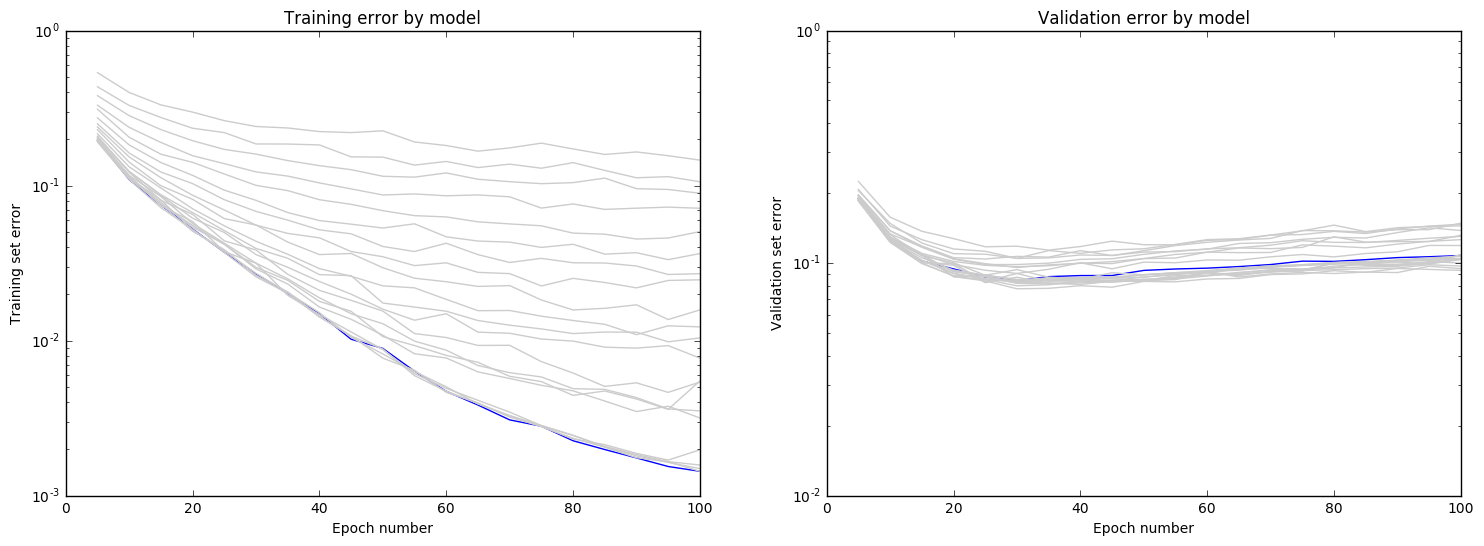

In [294]:

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# combos_to_plot_idx = [0, 1, 2]

ii = 0
hyperparams_to_plot = run_infos.keys()
for hps in hyperparams_to_plot:
    if run_infos[hps] is None:
        continue
    if ii == 0:
        color = 'b'
        label = 'baseline model'
    else:
        if ii == 1:
            label = 'batch normalization model'
        else:
            label = None
        color = '0.8'
    stats, keys, run_time = run_infos[hps]
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], color, label=label)
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], color, label=label)
    ii += 1
# ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax1.set_title('Training error by model')
# ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
ax2.set_title('Validation error by model')

plt.savefig(os.path.join(save_path, 'gray_vs_baseline_blue.pdf'))
plt.show()




# # Plot stuff
# fig = plt.figure(figsize=(18, 6))
# ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2)

# print run_infos.keys()
# hyperparams_to_plot = [(0., 0.), (1., 0.33)]
# hyperparams_to_plot = run_infos.keys()
# for hps in hyperparams_to_plot:
#     if run_infos[hps] is None:
#         continue
#     stats, keys, run_time = run_infos[hps]
#     hps_pretty = 'sigma max = {0:.2g}, proportion augmented = {1:.2g}'.format(hps[0], hps[1])
#     print hps_pretty
#     ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#              stats[1:, keys['error(train)']], label=hps_pretty)
#     ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#              stats[1:, keys['error(valid)']], label=hps_pretty)

# # ax1.legend(loc=0)
# ax1.set_xlabel('Epoch number')
# ax1.set_ylabel('Training set error')
# ax1.set_yscale('log')
# ax1.set_title('Training error by model')
# # ax2.legend(loc=0)
# ax2.set_xlabel('Epoch number')
# ax2.set_ylabel('Validation set error')
# ax2.set_yscale('log')
# ax2.set_title('Validation error by model')

# #     plt.savefig(os.path.join(save_path, filename))
# plt.show()    

# Experiment 3: batch normalization

In [186]:
from mlp.data_providers import AugmentedMNISTDataProvider  # *********

import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer, ReluLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.001
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [187]:
from mlp.layers import Layer

class BatchNormLayer(Layer):
    
    def __init__(self, beta = 0., gamma = 1., epsilon = 1e-5):
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon

    # Stuff tried from link given in slides:
    # http://cthorey.github.io/backpropagation/.
    def fprop_BAD_DONT_USE_DELETE_AWFUL(self, h):
        
        N, D = h.shape
        mu = 1/N*np.sum(h,axis =0) # Size (H,) 
        sigma2 = 1/N*np.sum((h-mu)**2,axis=0)# Size (H,) 
        hath = (h-mu)*(sigma2+self.epsilon)**(-1./2.)
        y = self.gamma*hath+self.beta
        return y
    
    def bprop_BAD_DONT_USE_DELETE_AWFUL(self, h, outputs, dy):
        
        N, D = h.shape
        mu = 1./N*np.sum(h, axis = 0)
        var = 1./N*np.sum((h-mu)**2, axis = 0)
        dbeta = np.sum(dy, axis=0)
        dgamma = np.sum((h - mu) * (var + self.epsilon)**(-1. / 2.) * dy, axis=0)
        dh = (1. / N) * self.gamma * (var + self.epsilon)**(-1. / 2.) * (N * dy - np.sum(dy, axis=0)
            - (h - mu) * (var + self.epsilon)**(-1.0) * np.sum(dy * (h - mu), axis=0))
        return dh
    
    # I didn't really like the code that was linked to in the slides.
    # Instead, I implemented the code found on the following github page,
    # making some tweaks so that it fits within the mlp framework:
    
    # https://github.com/yanji84/neural-network/blob/master/core/layers.py
    
    def fprop(self, inputs):
    
        N, D = inputs.shape
        mu = 1./N * np.sum(inputs, axis = 0)
        xmu = inputs - mu
        sq = xmu ** 2
        var = 1./N * np.sum(sq, axis = 0)
        sqrtvar = np.sqrt(var + self.epsilon)
        ivar = 1./sqrtvar
        xhat = xmu * ivar
        gammax = self.gamma * xhat
        out = gammax + self.beta
        self.cache = (xhat,xmu,ivar,sqrtvar,var)

        return out
    
    
    def bprop(self, inputs, outputs, grads_wrt_outputs):

        xhat,xmu,ivar,sqrtvar,var = self.cache
        N,D = grads_wrt_outputs.shape
        dbeta = np.sum(grads_wrt_outputs, axis=0)
        dgammax = grads_wrt_outputs
        dgamma = np.sum(dgammax*xhat, axis=0)
        dxhat = dgammax * self.gamma
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar
        dsqrtvar = -1. /(sqrtvar**2) * divar
        dvar = 0.5 * 1. /np.sqrt(var+self.epsilon) * dsqrtvar
        dsq = 1. /N * np.ones((N,D)) * dvar
        dxmu2 = 2 * xmu * dsq
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
        dx2 = 1. /N * np.ones((N,D)) * dmu
        dx = dx1 + dx2

        return dx
    
    
    def __repr__(self):
        return 'BatchNormLayer'

In [188]:
# combos = []
# for beta in betas:
#     for gamma in gammas:
#         combos.append((beta, gamma))
# print combos
# print combos.pop(0)
# print combos

path created: run/coursework2/batch_norm/2016-11-23
deleting files in: run/coursework2/batch_norm/2016-11-23
--------------------------------------------------------------------------------
baseline
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 1.96s to complete
  error(train)=2.98e-01, acc(train)=9.16e-01, error(valid)=2.75e-01, acc(valid)=9.23e-01, params_penalty=0.00e+00
Epoch 10: 2.17s to complete
  error(train)=2.17e-01, acc(train)=9.38e-01, error(valid)=2.07e-01, acc(valid)=9.42e-01, params_penalty=0.00e+00
Epoch 15: 2.96s to complete
  error(train)=1.65e-01, acc(train)=9.53e-01, error(valid)=1.63e-01, acc(valid)=9.54e-01, params_penalty=0.00e+00
Epoch 20: 2.41s to complete
  error(train)=1.32e-01, acc(train)=9.63e-01, error(valid)=1.39e-01, acc(valid)=9.60e-01, params_penalty=0.00e+00
Epoch 25: 1.67s to complete
  error(train)=1.08e-01, acc(train)=9.69e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 30: 1.70s to complete
  error(train)=8.92e-02, acc(train)=9.75e-01, error(valid)=1.11e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 35: 1.66s to complet

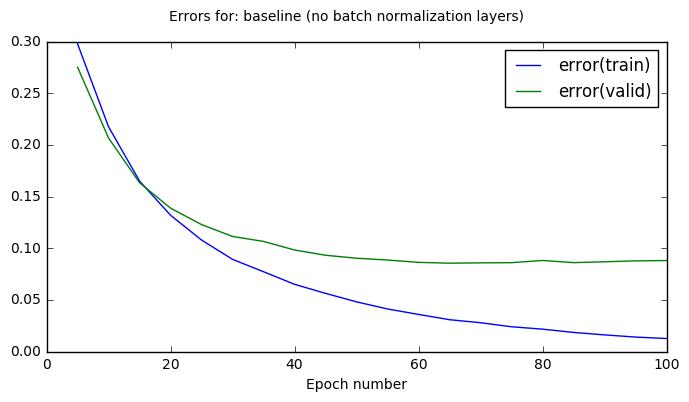

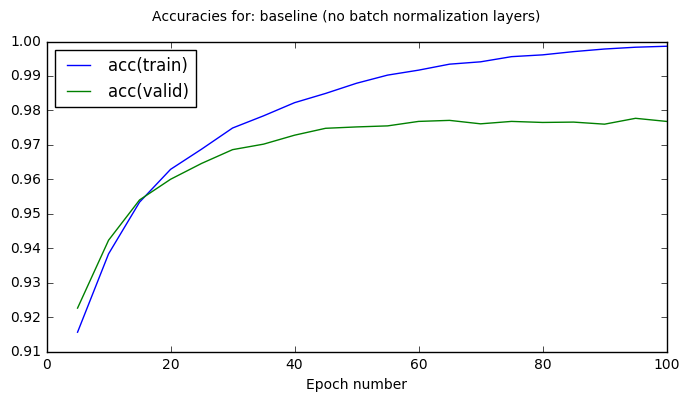

--------------------------------------------------------------------------------
beta_0_gamma_0.11
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.13e-01, error(valid)=2.31e+00, acc(valid)=1.11e-01, params_penalty=0.00e+00
Epoch 5: 2.41s to complete
  error(train)=9.99e-01, acc(train)=8.73e-01, error(valid)=9.86e-01, acc(valid)=8.79e-01, params_penalty=0.00e+00
Epoch 10: 2.66s to complete
  error(train)=5.51e-01, acc(train)=9.36e-01, error(valid)=5.40e-01, acc(valid)=9.36e-01, params_penalty=0.00e+00
Epoch 15: 2.68s to complete
  error(train)=3.57e-01, acc(train)=9.56e-01, error(valid)=3.57e-01, acc(valid)=9.55e-01, params_penalty=0.00e+00
Epoch 20: 2.33s to complete
  error(train)=2.59e-01, acc(train)=9.68e-01, error(valid)=2.71e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 25: 2.99s to complete
  error(train)=2.01e-01, acc(train)=9.75e-01, error(valid)=2.18e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 30: 2.38s to complete
  error(train)=1.66e-01, acc(train)=9.80e-01, error(valid)=1.94e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 35: 2.27s to complet

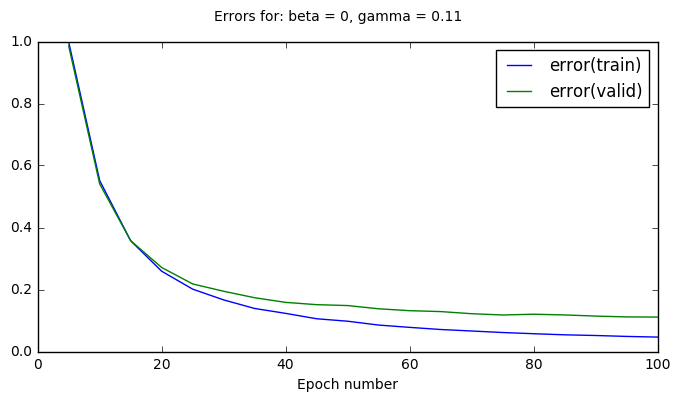

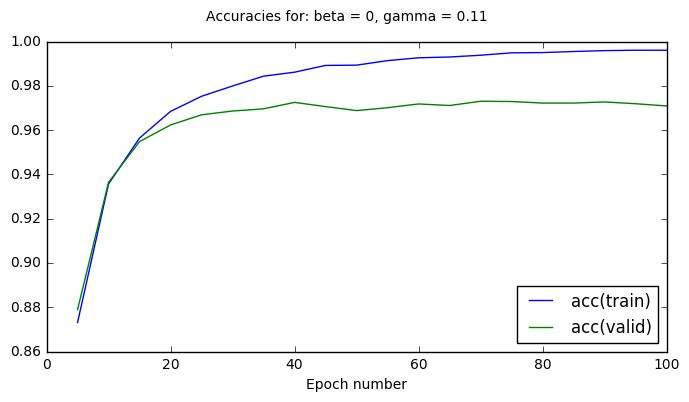

--------------------------------------------------------------------------------
beta_0_gamma_0.33
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.32e+00, acc(train)=1.24e-01, error(valid)=2.31e+00, acc(valid)=1.35e-01, params_penalty=0.00e+00
Epoch 5: 2.47s to complete
  error(train)=2.31e-01, acc(train)=9.51e-01, error(valid)=2.30e-01, acc(valid)=9.51e-01, params_penalty=0.00e+00
Epoch 10: 2.58s to complete
  error(train)=1.28e-01, acc(train)=9.73e-01, error(valid)=1.45e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 15: 2.17s to complete
  error(train)=8.86e-02, acc(train)=9.82e-01, error(valid)=1.21e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 2.08s to complete
  error(train)=6.68e-02, acc(train)=9.87e-01, error(valid)=1.08e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 25: 2.37s to complete
  error(train)=5.38e-02, acc(train)=9.90e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 30: 2.14s to complete
  error(train)=4.52e-02, acc(train)=9.92e-01, error(valid)=1.04e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 2.09s to complet

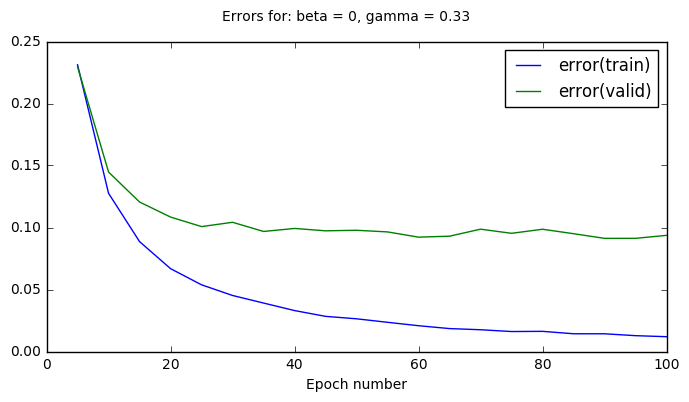

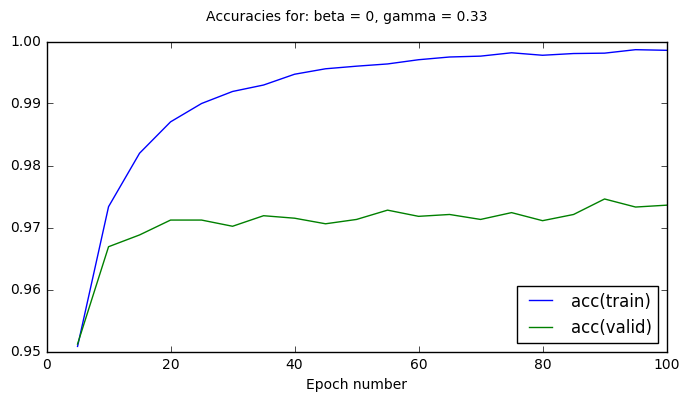

--------------------------------------------------------------------------------
beta_0_gamma_1
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.36e+00, acc(train)=1.03e-01, error(valid)=2.35e+00, acc(valid)=1.08e-01, params_penalty=0.00e+00
Epoch 5: 2.36s to complete
  error(train)=9.90e-02, acc(train)=9.74e-01, error(valid)=1.23e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 10: 2.21s to complete
  error(train)=5.65e-02, acc(train)=9.86e-01, error(valid)=9.97e-02, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 2.19s to complete
  error(train)=3.94e-02, acc(train)=9.90e-01, error(valid)=9.39e-02, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.15s to complete
  error(train)=2.75e-02, acc(train)=9.94e-01, error(valid)=8.84e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 25: 2.51s to complete
  error(train)=2.21e-02, acc(train)=9.95e-01, error(valid)=9.17e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.83s to complete
  error(train)=1.79e-02, acc(train)=9.96e-01, error(valid)=9.08e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 2.51s to complet

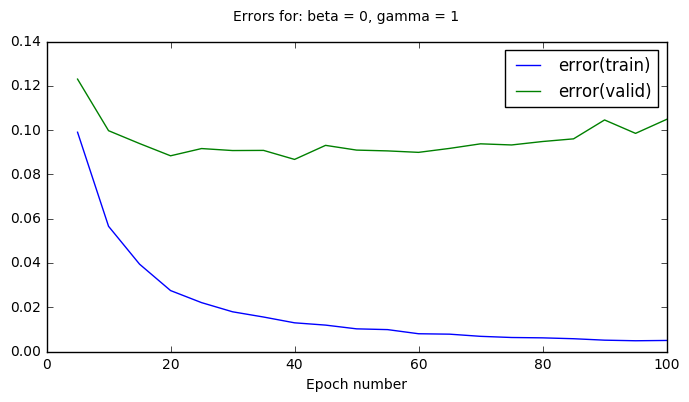

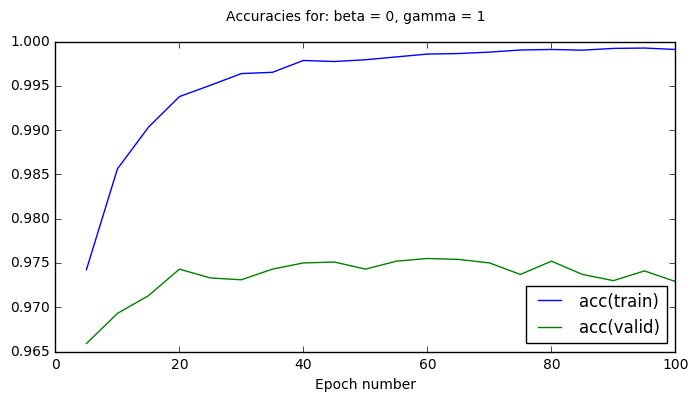

--------------------------------------------------------------------------------
beta_0.11_gamma_0.11
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.31e+00, acc(train)=8.31e-02, error(valid)=2.31e+00, acc(valid)=8.81e-02, params_penalty=0.00e+00
Epoch 5: 2.14s to complete
  error(train)=7.73e-01, acc(train)=8.93e-01, error(valid)=7.49e-01, acc(valid)=9.05e-01, params_penalty=0.00e+00
Epoch 10: 3.15s to complete
  error(train)=4.39e-01, acc(train)=9.34e-01, error(valid)=4.25e-01, acc(valid)=9.41e-01, params_penalty=0.00e+00
Epoch 15: 2.64s to complete
  error(train)=2.85e-01, acc(train)=9.56e-01, error(valid)=2.86e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00
Epoch 20: 2.25s to complete
  error(train)=2.11e-01, acc(train)=9.68e-01, error(valid)=2.22e-01, acc(valid)=9.60e-01, params_penalty=0.00e+00
Epoch 25: 2.17s to complete
  error(train)=1.66e-01, acc(train)=9.74e-01, error(valid)=1.86e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 30: 2.47s to complete
  error(train)=1.39e-01, acc(train)=9.79e-01, error(valid)=1.60e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 35: 2.11s to complet

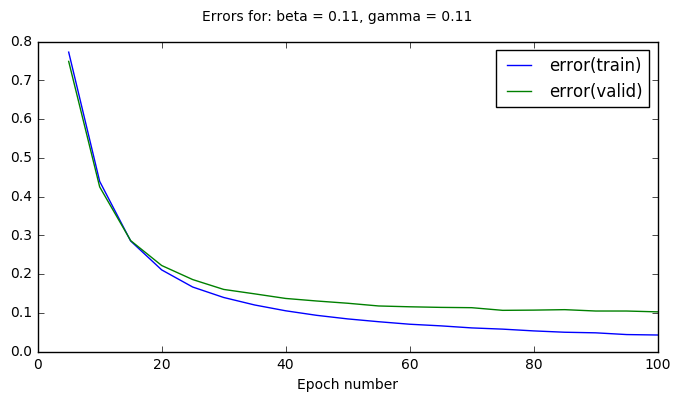

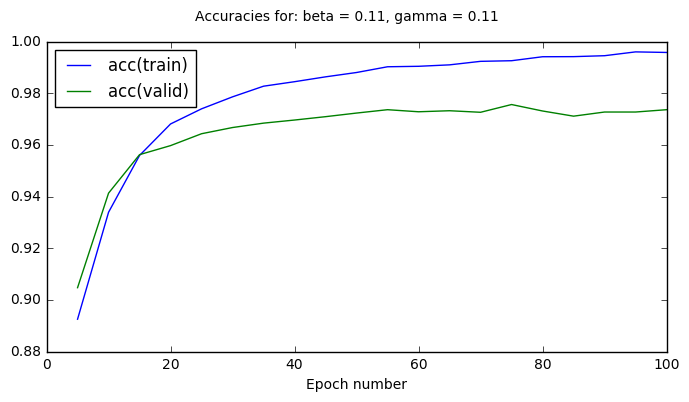

--------------------------------------------------------------------------------
beta_0.11_gamma_0.33
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.53e-01, error(valid)=2.31e+00, acc(valid)=1.40e-01, params_penalty=0.00e+00
Epoch 5: 2.84s to complete
  error(train)=2.08e-01, acc(train)=9.55e-01, error(valid)=2.03e-01, acc(valid)=9.56e-01, params_penalty=0.00e+00
Epoch 10: 2.60s to complete
  error(train)=1.16e-01, acc(train)=9.76e-01, error(valid)=1.33e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 2.09s to complete
  error(train)=8.23e-02, acc(train)=9.83e-01, error(valid)=1.12e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 20: 2.48s to complete
  error(train)=6.31e-02, acc(train)=9.87e-01, error(valid)=1.03e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 2.66s to complete
  error(train)=5.08e-02, acc(train)=9.90e-01, error(valid)=9.74e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 30: 2.07s to complete
  error(train)=4.09e-02, acc(train)=9.93e-01, error(valid)=9.53e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 35: 2.15s to complet

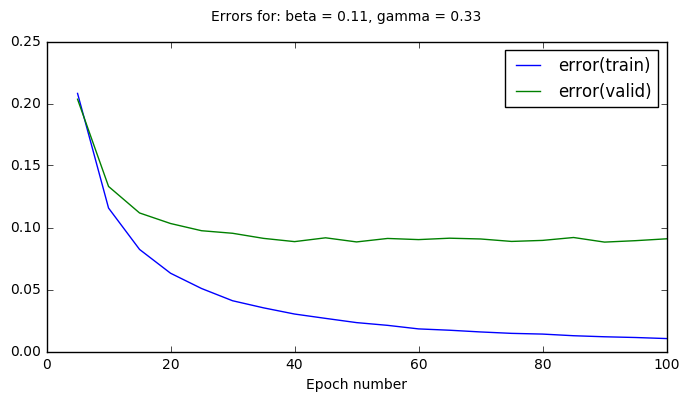

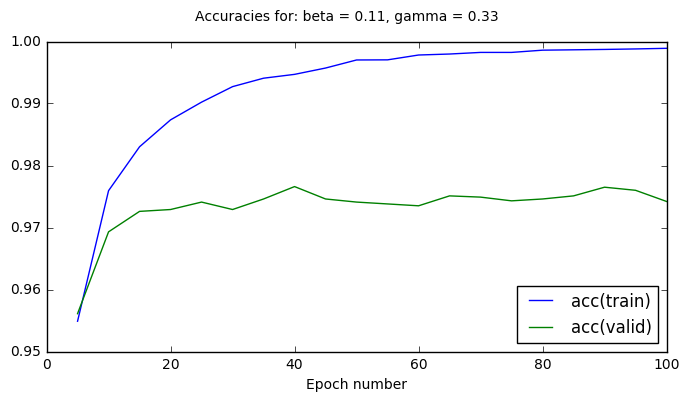

--------------------------------------------------------------------------------
beta_0.11_gamma_1
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.42e+00, acc(train)=7.24e-02, error(valid)=2.41e+00, acc(valid)=7.47e-02, params_penalty=0.00e+00
Epoch 5: 2.40s to complete
  error(train)=9.74e-02, acc(train)=9.74e-01, error(valid)=1.17e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 10: 2.22s to complete
  error(train)=5.36e-02, acc(train)=9.87e-01, error(valid)=9.80e-02, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 15: 2.16s to complete
  error(train)=3.62e-02, acc(train)=9.92e-01, error(valid)=9.41e-02, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.25s to complete
  error(train)=2.67e-02, acc(train)=9.94e-01, error(valid)=9.55e-02, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 25: 2.24s to complete
  error(train)=2.10e-02, acc(train)=9.95e-01, error(valid)=8.91e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 30: 2.39s to complete
  error(train)=1.72e-02, acc(train)=9.97e-01, error(valid)=8.58e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 35: 2.71s to complet

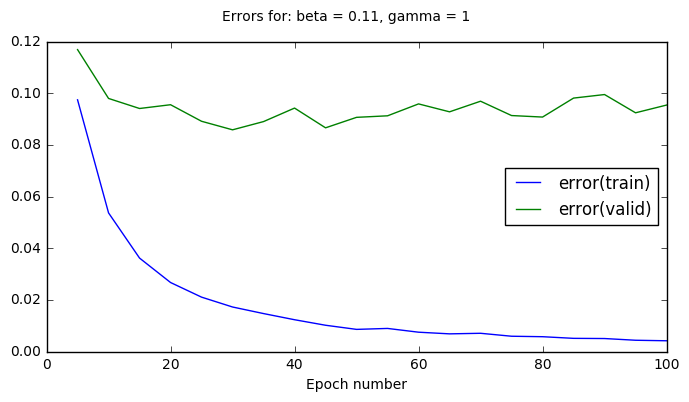

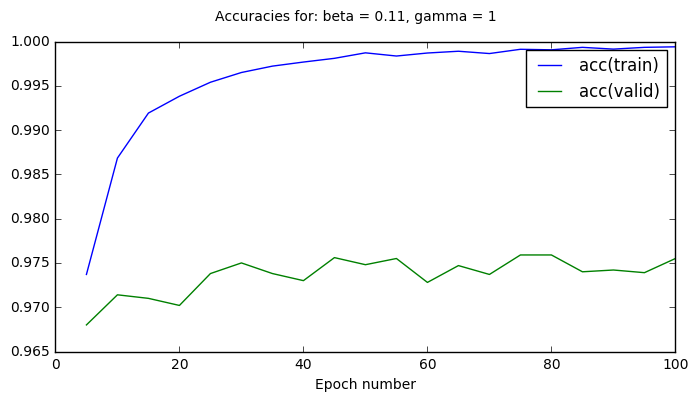

--------------------------------------------------------------------------------
beta_0.33_gamma_0.11
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.34e+00, acc(train)=1.46e-01, error(valid)=2.34e+00, acc(valid)=1.52e-01, params_penalty=0.00e+00
Epoch 5: 2.12s to complete
  error(train)=8.01e-01, acc(train)=8.78e-01, error(valid)=7.78e-01, acc(valid)=8.86e-01, params_penalty=0.00e+00
Epoch 10: 2.23s to complete
  error(train)=5.69e-01, acc(train)=8.93e-01, error(valid)=5.42e-01, acc(valid)=9.03e-01, params_penalty=0.00e+00
Epoch 15: 2.40s to complete
  error(train)=4.78e-01, acc(train)=9.00e-01, error(valid)=4.58e-01, acc(valid)=9.06e-01, params_penalty=0.00e+00
Epoch 20: 2.50s to complete
  error(train)=4.28e-01, acc(train)=9.04e-01, error(valid)=4.12e-01, acc(valid)=9.09e-01, params_penalty=0.00e+00
Epoch 25: 2.27s to complete
  error(train)=3.93e-01, acc(train)=9.09e-01, error(valid)=3.82e-01, acc(valid)=9.12e-01, params_penalty=0.00e+00
Epoch 30: 2.14s to complete
  error(train)=3.69e-01, acc(train)=9.14e-01, error(valid)=3.57e-01, acc(valid)=9.15e-01, params_penalty=0.00e+00
Epoch 35: 2.23s to complet

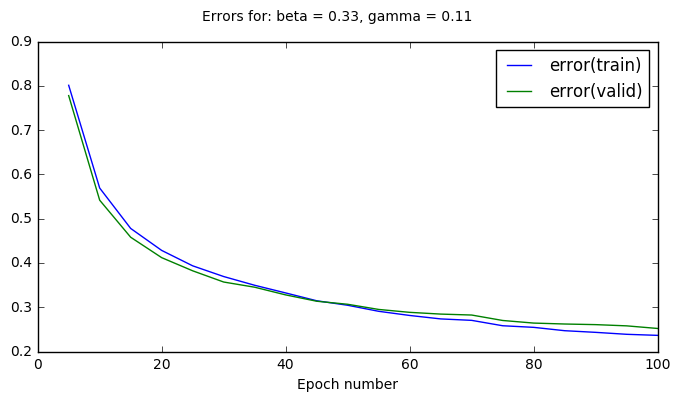

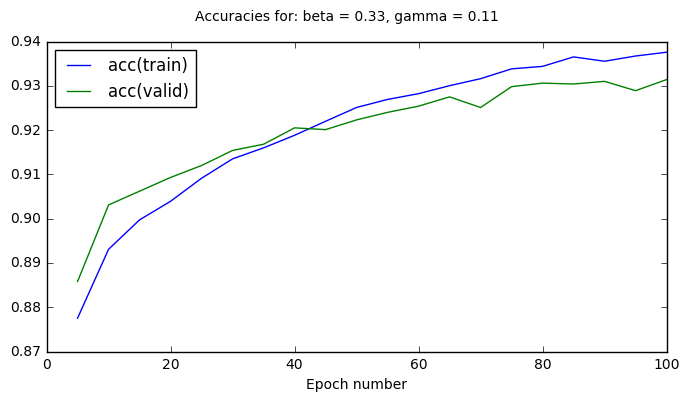

--------------------------------------------------------------------------------
beta_0.33_gamma_0.33
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.37e+00, acc(train)=1.20e-01, error(valid)=2.37e+00, acc(valid)=1.19e-01, params_penalty=0.00e+00
Epoch 5: 2.20s to complete
  error(train)=2.49e-01, acc(train)=9.41e-01, error(valid)=2.39e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 10: 2.10s to complete
  error(train)=1.38e-01, acc(train)=9.67e-01, error(valid)=1.51e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00
Epoch 15: 2.16s to complete
  error(train)=9.67e-02, acc(train)=9.79e-01, error(valid)=1.25e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 2.28s to complete
  error(train)=7.53e-02, acc(train)=9.83e-01, error(valid)=1.17e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 25: 2.43s to complete
  error(train)=5.94e-02, acc(train)=9.87e-01, error(valid)=1.06e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 30: 2.20s to complete
  error(train)=4.97e-02, acc(train)=9.90e-01, error(valid)=1.05e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 3.23s to complet

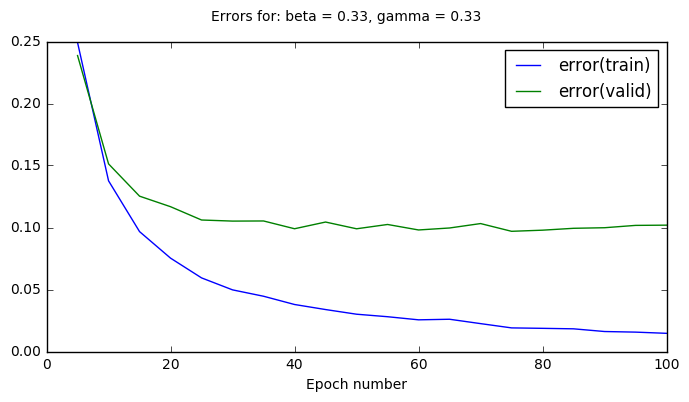

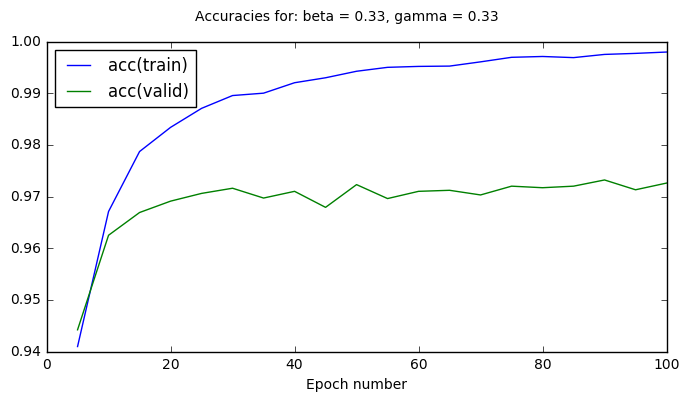

--------------------------------------------------------------------------------
beta_0.33_gamma_1
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.42e+00, acc(train)=1.36e-01, error(valid)=2.43e+00, acc(valid)=1.32e-01, params_penalty=0.00e+00
Epoch 5: 2.26s to complete
  error(train)=1.02e-01, acc(train)=9.73e-01, error(valid)=1.22e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 2.42s to complete
  error(train)=5.79e-02, acc(train)=9.85e-01, error(valid)=1.01e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 2.57s to complete
  error(train)=3.86e-02, acc(train)=9.91e-01, error(valid)=9.61e-02, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 20: 2.25s to complete
  error(train)=2.80e-02, acc(train)=9.94e-01, error(valid)=9.27e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 2.26s to complete
  error(train)=2.19e-02, acc(train)=9.95e-01, error(valid)=9.80e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 2.20s to complete
  error(train)=1.77e-02, acc(train)=9.96e-01, error(valid)=9.26e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 2.26s to complet

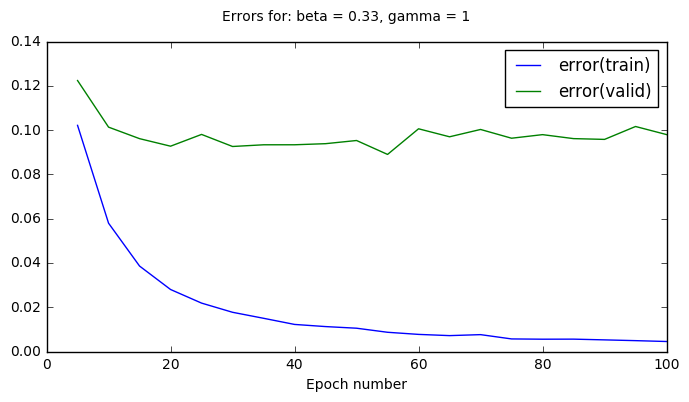

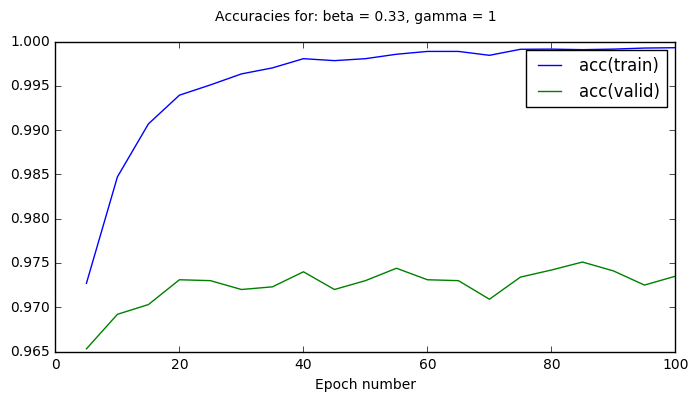

--------------------------------------------------------------------------------
beta_1_gamma_0.11
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.55e+00, acc(train)=7.71e-02, error(valid)=2.55e+00, acc(valid)=7.44e-02, params_penalty=0.00e+00
Epoch 5: 3.33s to complete
  error(train)=7.97e-01, acc(train)=8.77e-01, error(valid)=7.69e-01, acc(valid)=8.90e-01, params_penalty=0.00e+00
Epoch 10: 2.29s to complete
  error(train)=5.68e-01, acc(train)=8.93e-01, error(valid)=5.40e-01, acc(valid)=9.02e-01, params_penalty=0.00e+00
Epoch 15: 2.25s to complete
  error(train)=4.79e-01, acc(train)=8.98e-01, error(valid)=4.61e-01, acc(valid)=9.06e-01, params_penalty=0.00e+00
Epoch 20: 2.37s to complete
  error(train)=4.30e-01, acc(train)=9.05e-01, error(valid)=4.07e-01, acc(valid)=9.11e-01, params_penalty=0.00e+00
Epoch 25: 2.66s to complete
  error(train)=4.01e-01, acc(train)=9.07e-01, error(valid)=3.83e-01, acc(valid)=9.14e-01, params_penalty=0.00e+00
Epoch 30: 2.14s to complete
  error(train)=3.78e-01, acc(train)=9.10e-01, error(valid)=3.66e-01, acc(valid)=9.13e-01, params_penalty=0.00e+00
Epoch 35: 2.20s to complet

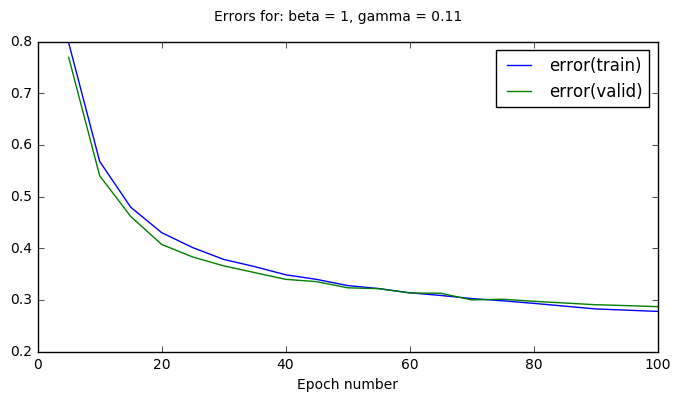

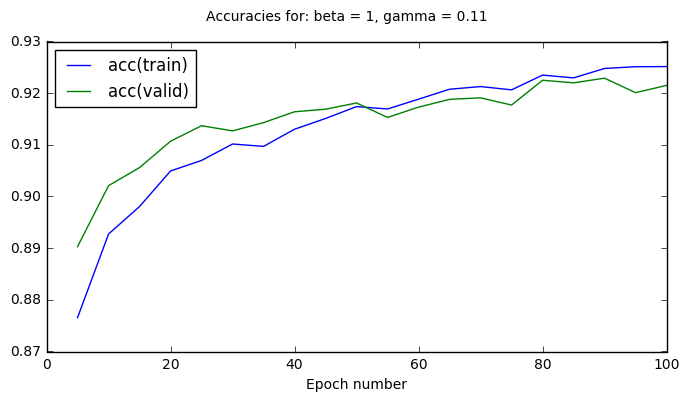

--------------------------------------------------------------------------------
beta_1_gamma_0.33
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.43e+00, acc(train)=8.86e-02, error(valid)=2.43e+00, acc(valid)=9.33e-02, params_penalty=0.00e+00
Epoch 5: 2.12s to complete
  error(train)=3.62e-01, acc(train)=9.07e-01, error(valid)=3.43e-01, acc(valid)=9.15e-01, params_penalty=0.00e+00
Epoch 10: 2.14s to complete
  error(train)=3.18e-01, acc(train)=9.14e-01, error(valid)=3.13e-01, acc(valid)=9.14e-01, params_penalty=0.00e+00
Epoch 15: 2.19s to complete
  error(train)=2.99e-01, acc(train)=9.17e-01, error(valid)=2.94e-01, acc(valid)=9.18e-01, params_penalty=0.00e+00
Epoch 20: 2.16s to complete
  error(train)=2.86e-01, acc(train)=9.18e-01, error(valid)=2.89e-01, acc(valid)=9.18e-01, params_penalty=0.00e+00
Epoch 25: 2.08s to complete
  error(train)=2.75e-01, acc(train)=9.23e-01, error(valid)=2.77e-01, acc(valid)=9.25e-01, params_penalty=0.00e+00
Epoch 30: 2.48s to complete
  error(train)=2.66e-01, acc(train)=9.24e-01, error(valid)=2.77e-01, acc(valid)=9.21e-01, params_penalty=0.00e+00
Epoch 35: 2.55s to complet

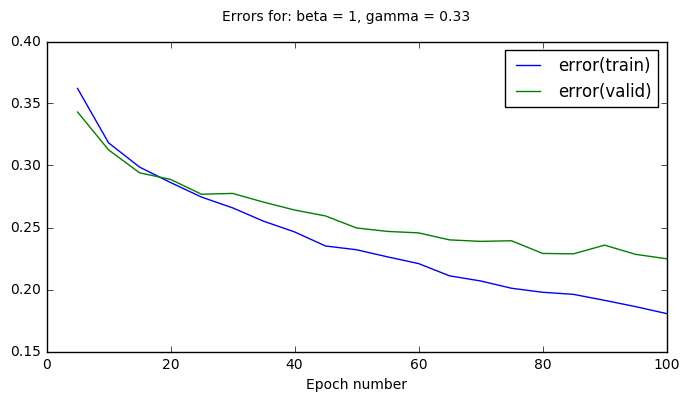

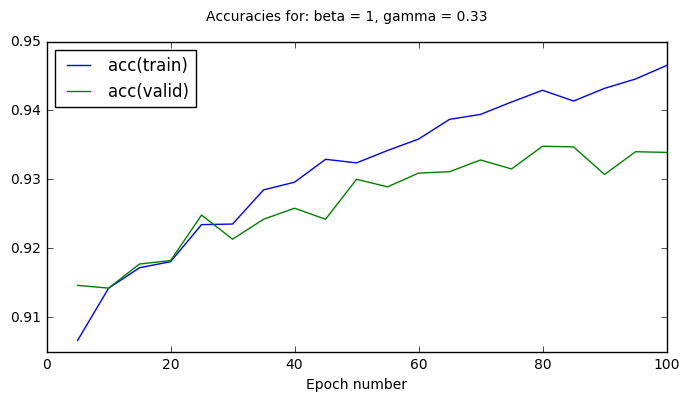

--------------------------------------------------------------------------------
beta_1_gamma_1
--------------------------------------------------------------------------------


Epoch 0:
  error(train)=2.99e+00, acc(train)=1.05e-01, error(valid)=3.00e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 5: 2.53s to complete
  error(train)=1.34e-01, acc(train)=9.63e-01, error(valid)=1.50e-01, acc(valid)=9.57e-01, params_penalty=0.00e+00
Epoch 10: 2.06s to complete
  error(train)=8.30e-02, acc(train)=9.75e-01, error(valid)=1.23e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 15: 2.43s to complete
  error(train)=5.38e-02, acc(train)=9.84e-01, error(valid)=1.05e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 20: 2.51s to complete
  error(train)=3.94e-02, acc(train)=9.90e-01, error(valid)=9.60e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 2.22s to complete
  error(train)=3.61e-02, acc(train)=9.90e-01, error(valid)=1.01e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 30: 2.16s to complete
  error(train)=2.74e-02, acc(train)=9.93e-01, error(valid)=1.03e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 35: 2.17s to complet

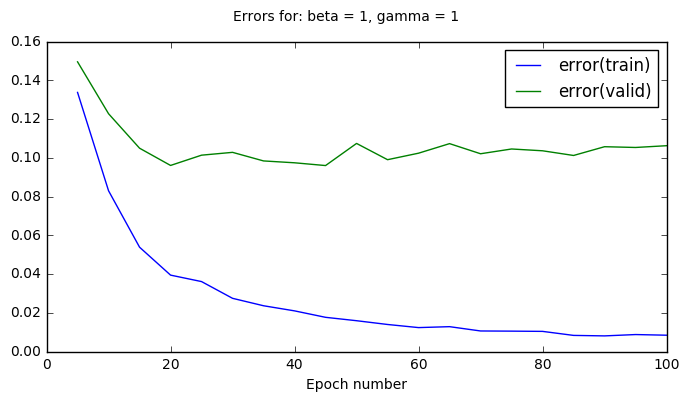

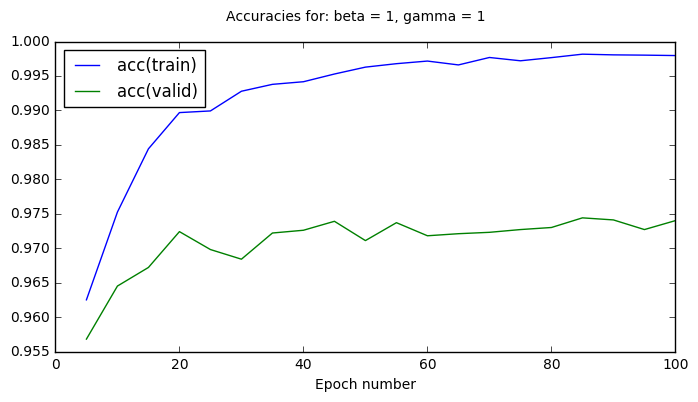

In [189]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'batch_norm'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Hyperparams to iterate over.
betas = [0., 1./9, 1./3, 1.]
gammas = [1./9, 1./3, 1.]

# betas = [0.]
# gammas = [1.]

# initial_matrix = np.ones((len(betas), len(gammas)), dtype='float') * float('inf')
run_infos = []
models = []
combo_strs = []
combo_strs_pretty = []

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

def create_beta_gamma_combos(beta, gamma):
    combos = []
    for beta in betas:
        for gamma in gammas:
            combos.append((beta, gamma))
    return combos

combos = create_beta_gamma_combos(beta, gamma)

i = 0
baseline_complete = False
while (i < len(combos)):
        
    if not baseline_complete:
        
        combo_str = 'baseline'
        combo_str_pretty = 'baseline (no batch normalization layers)'

        # No batch norm layer
        model = MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, 
                        biases_init),
            # BatchNormLayer(beta, gamma),
            ReluLayer(),
        #     SigmoidLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, 
                        biases_init),
            # BatchNormLayer(beta, gamma),
            ReluLayer(),
        #     SigmoidLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, 
                        biases_init)
        ])
    else:
        
#         beta, gamma = combos.pop(0)
        
        beta, gamma = combos[i]
        i += 1
        
        combo_str = 'beta_{0:.2g}_gamma_{1:.2g}'.format(beta, gamma)
        combo_str_pretty = 'beta = {0:.2g}, gamma = {1:.2g}'.format(beta, gamma)

        # No batch norm layer
        model = MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, 
                        biases_init),
            BatchNormLayer(beta, gamma),
            ReluLayer(),
        #     SigmoidLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, 
                        biases_init),
            BatchNormLayer(beta, gamma),
            ReluLayer(),
        #     SigmoidLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, 
                        biases_init)
        ])
            
    print('-' * 80)
    print(combo_str)
    print('-' * 80)

    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    run_info = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    stats, keys, run_time = run_info

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle('Errors for: ' + combo_str_pretty)

    plt.savefig(os.path.join(save_path, 'error_' + combo_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle('Accuracies for: ' + combo_str_pretty)

    plt.savefig(os.path.join(save_path, 'acc_' + combo_str + '.pdf'))
    
    plt.show()

    run_infos.append(run_info)
    models.append(model)
    combo_strs.append(combo_str)
    combo_strs_pretty.append(combo_str_pretty)
    

    baseline_complete = True

# Pickle all important objects
pickle.dump(run_infos, open(os.path.join(save_path_main, subdir, "run_infos.p"), "wb"))
pickle.dump(models,    open(os.path.join(save_path_main, subdir, "models.p"), "wb"))

Plot everything

path created: run/coursework2/batch_norm/2016-11-23
deleting files in: run/coursework2/batch_norm/2016-11-23


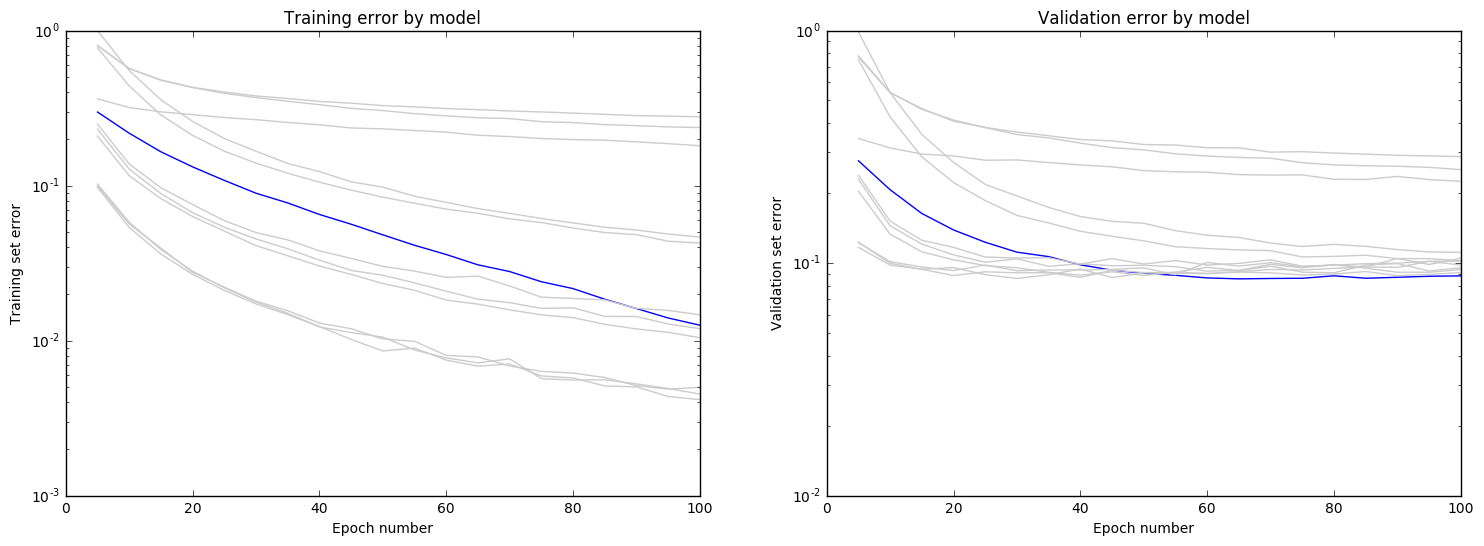

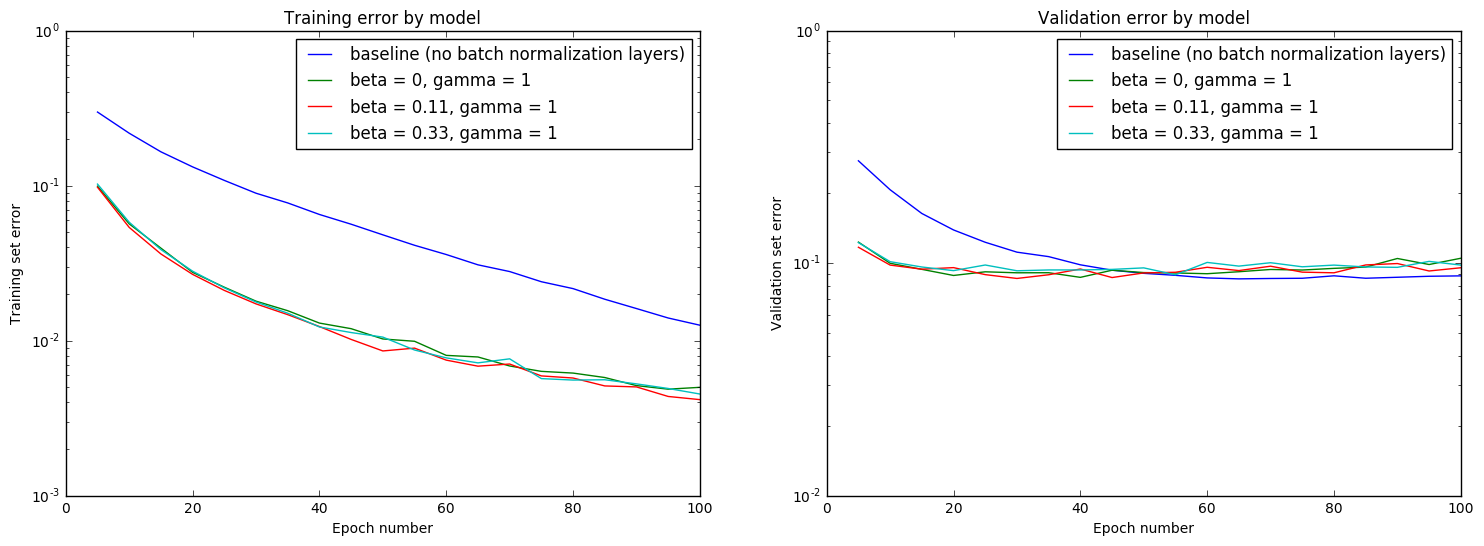

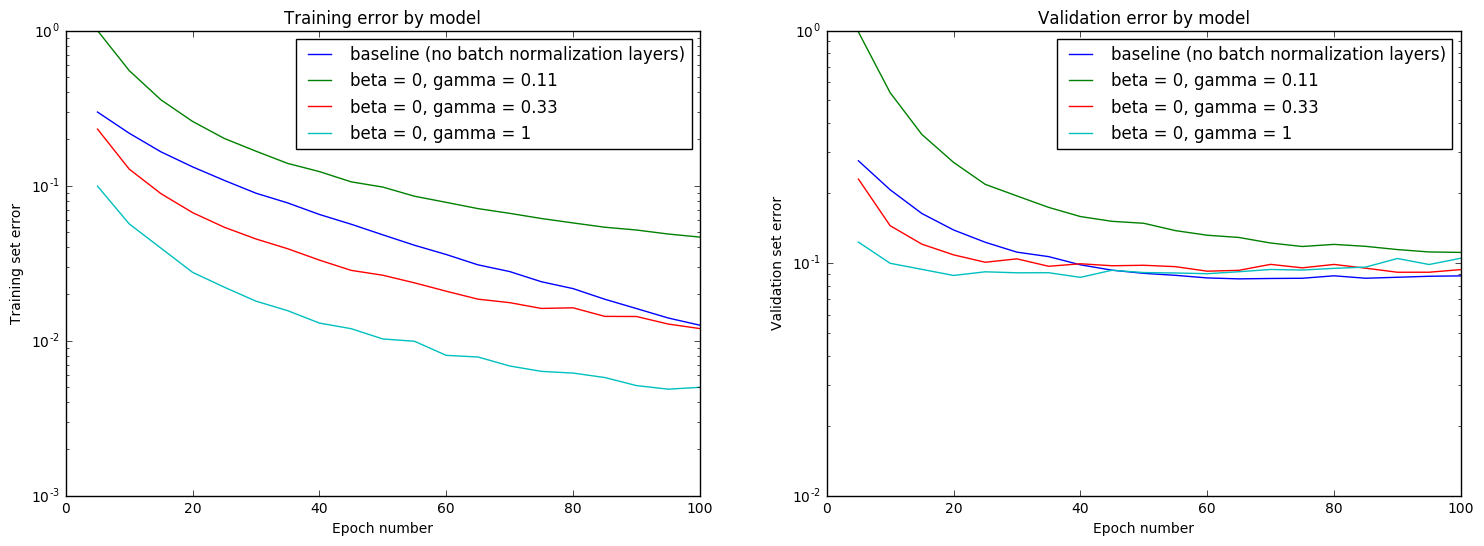

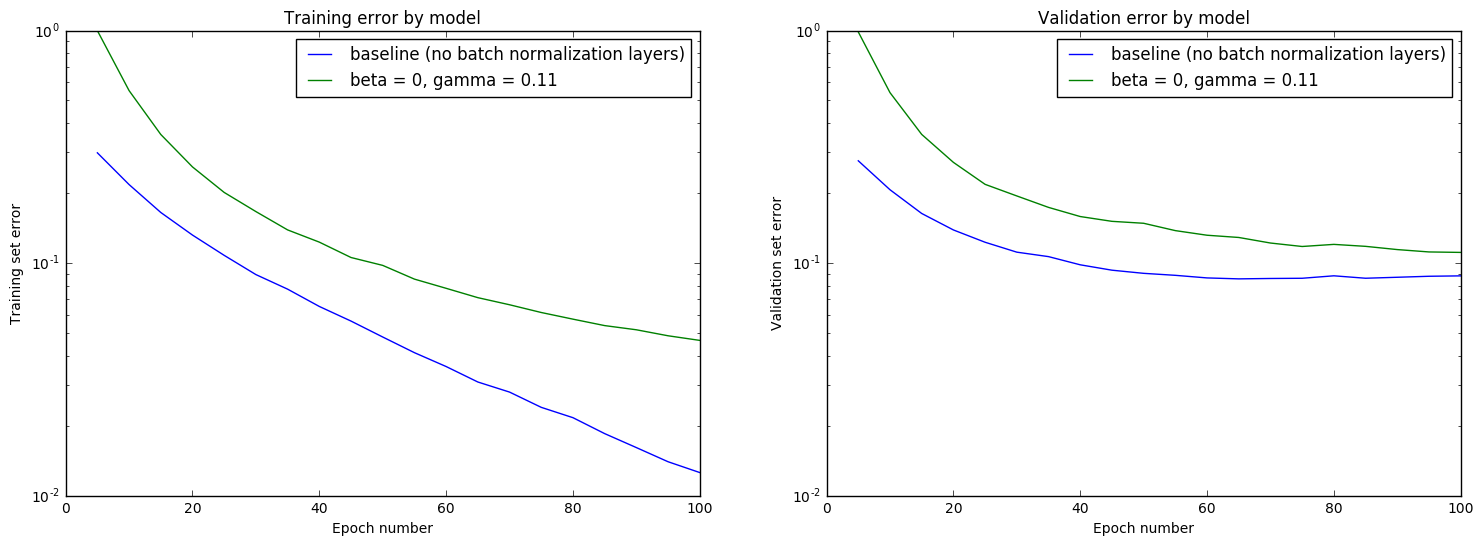

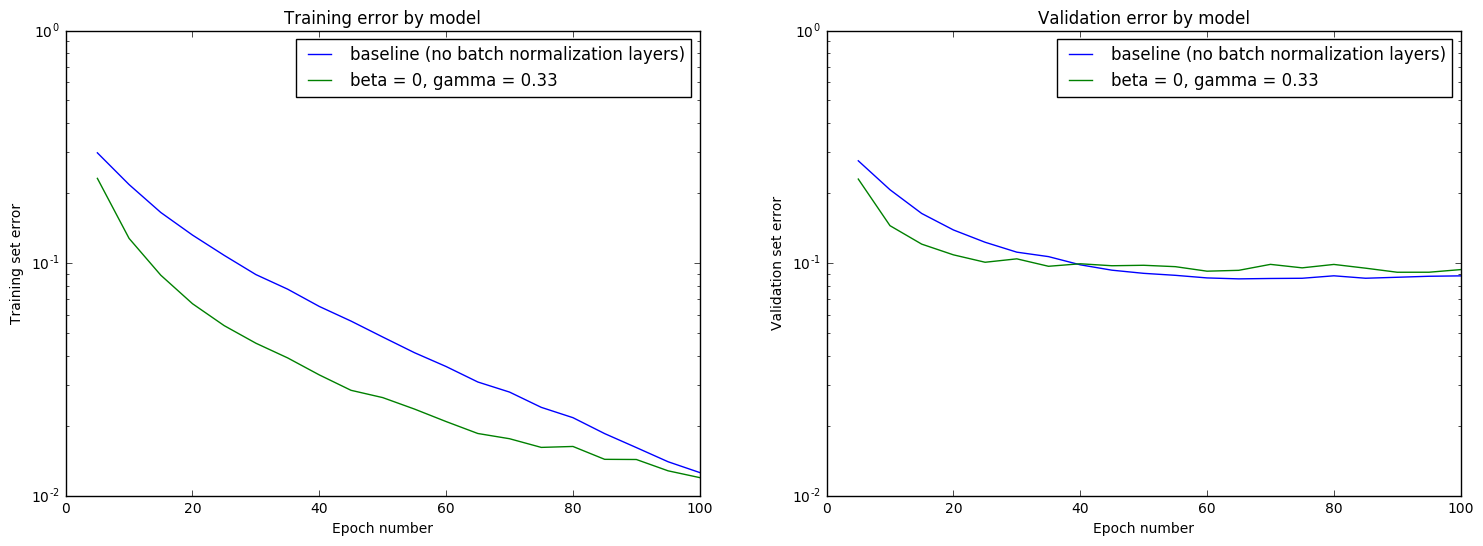

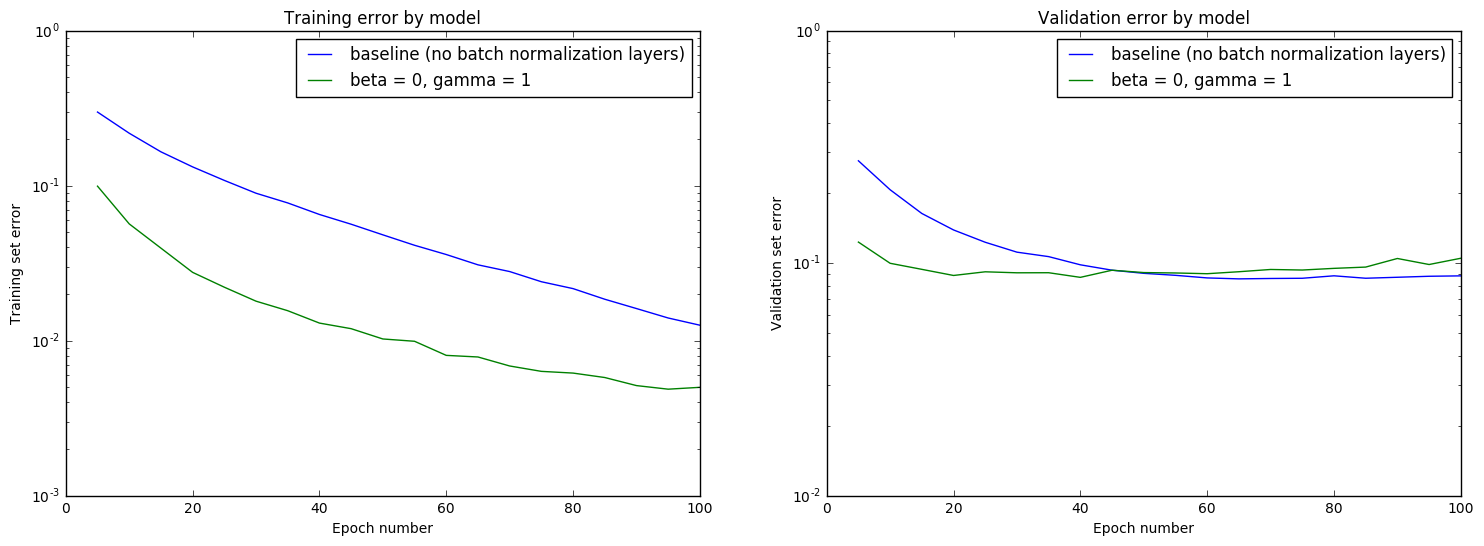

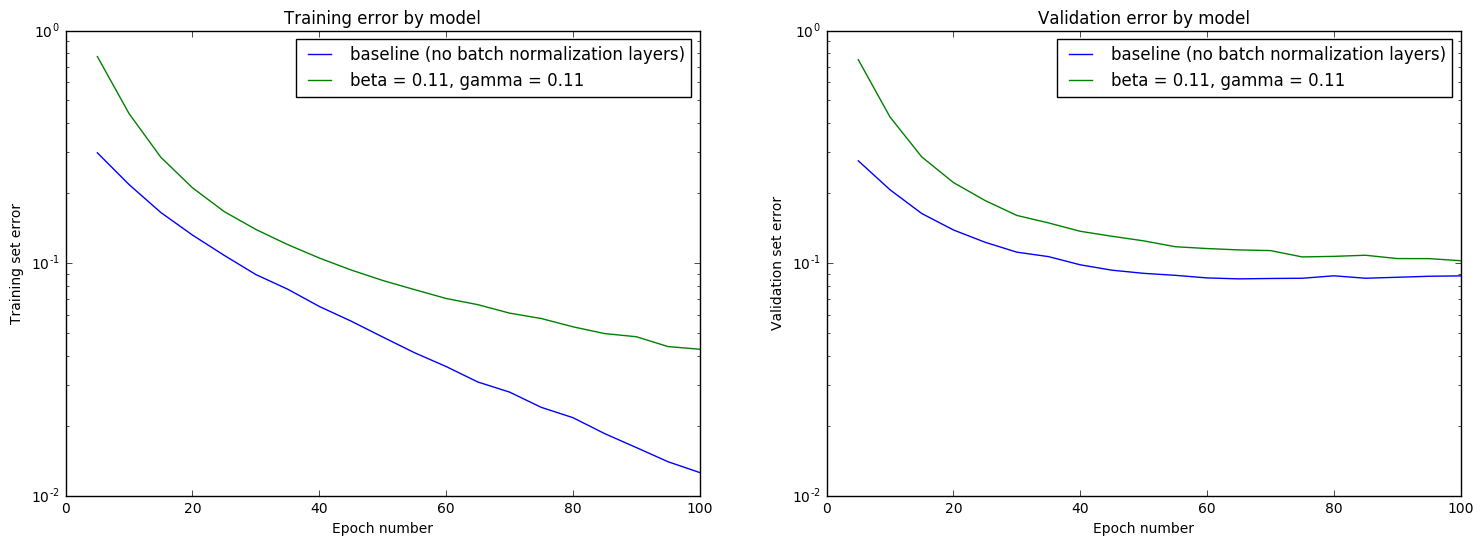

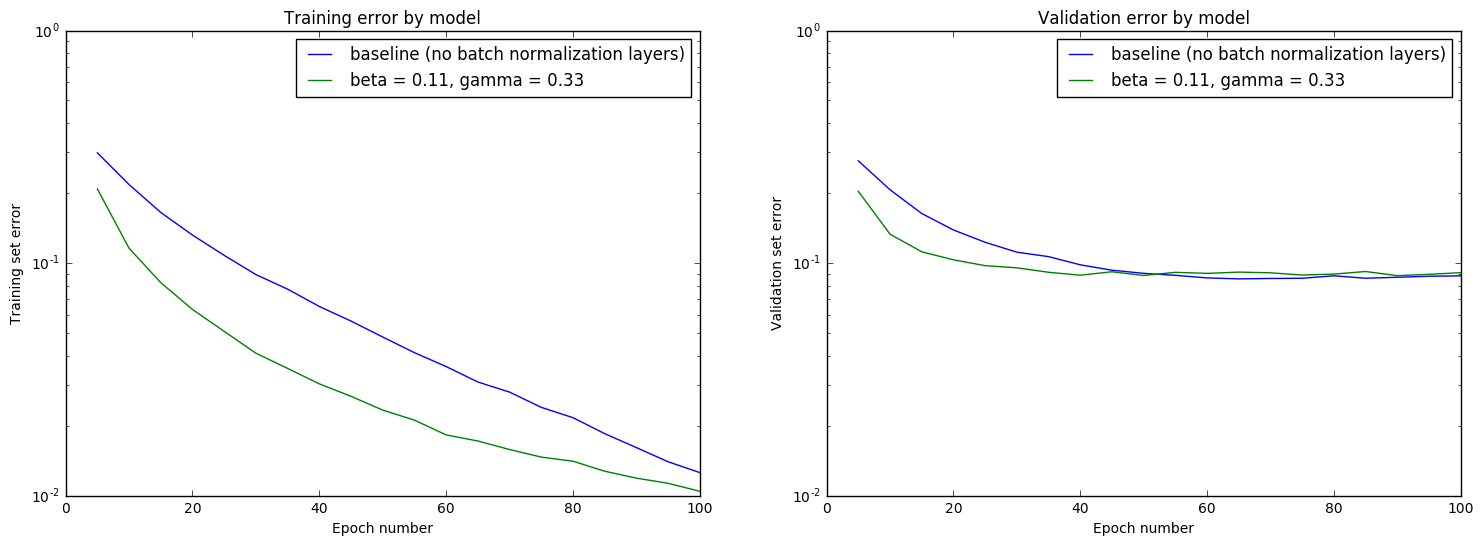

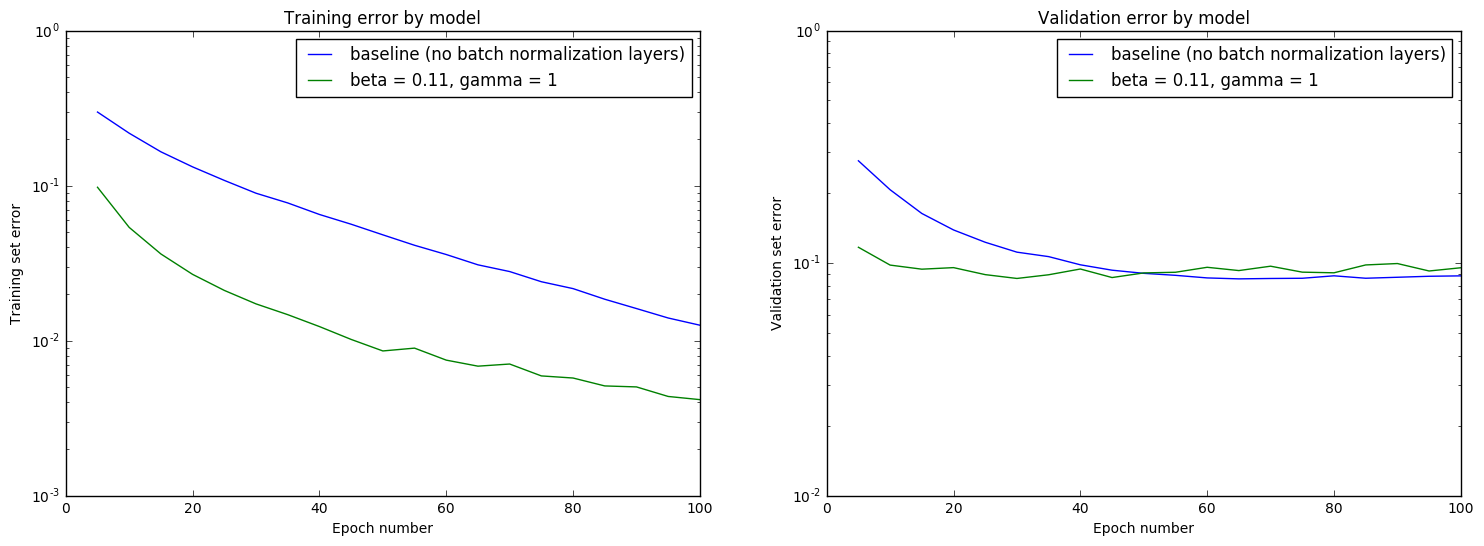

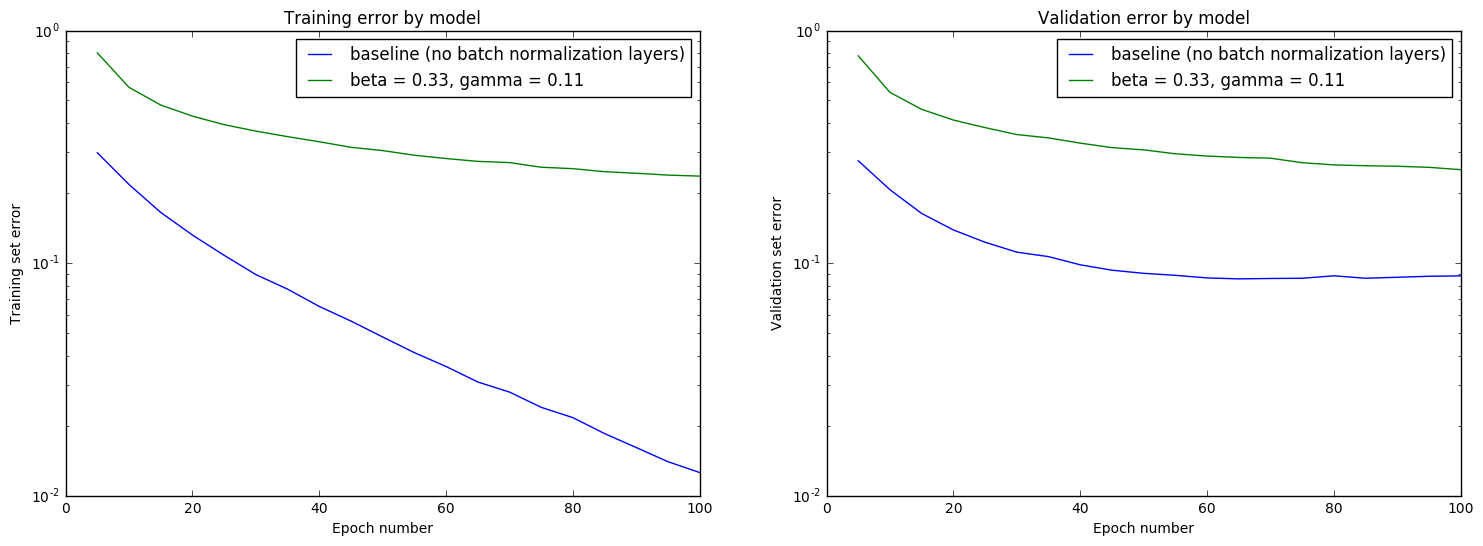

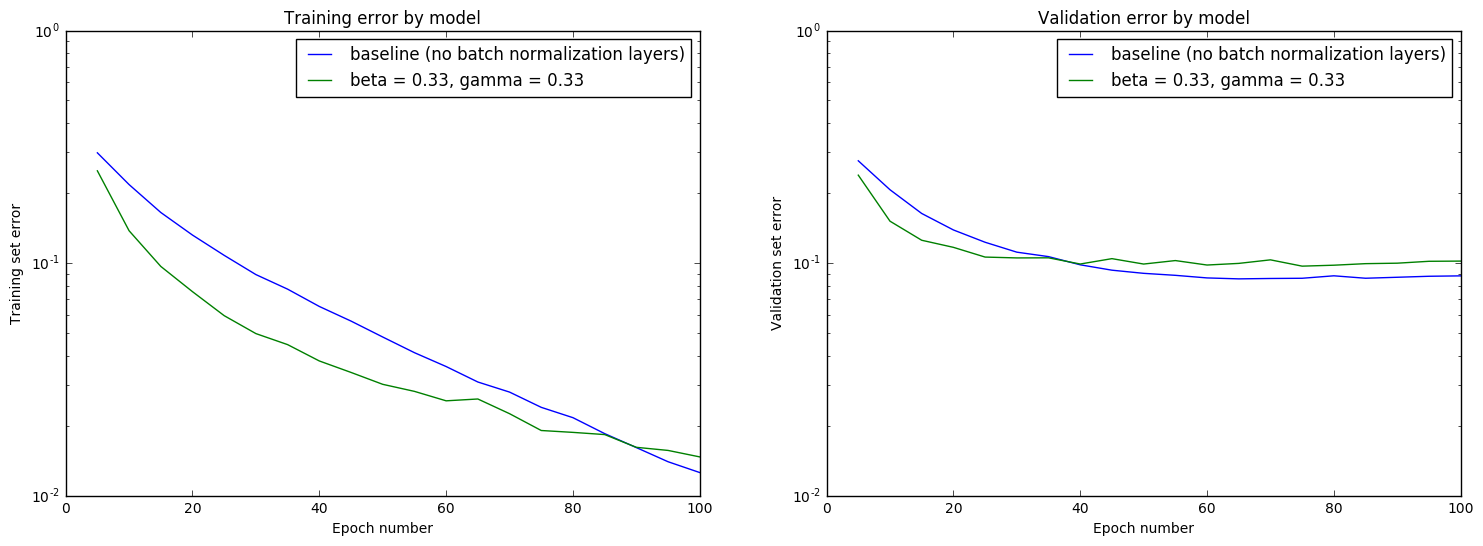

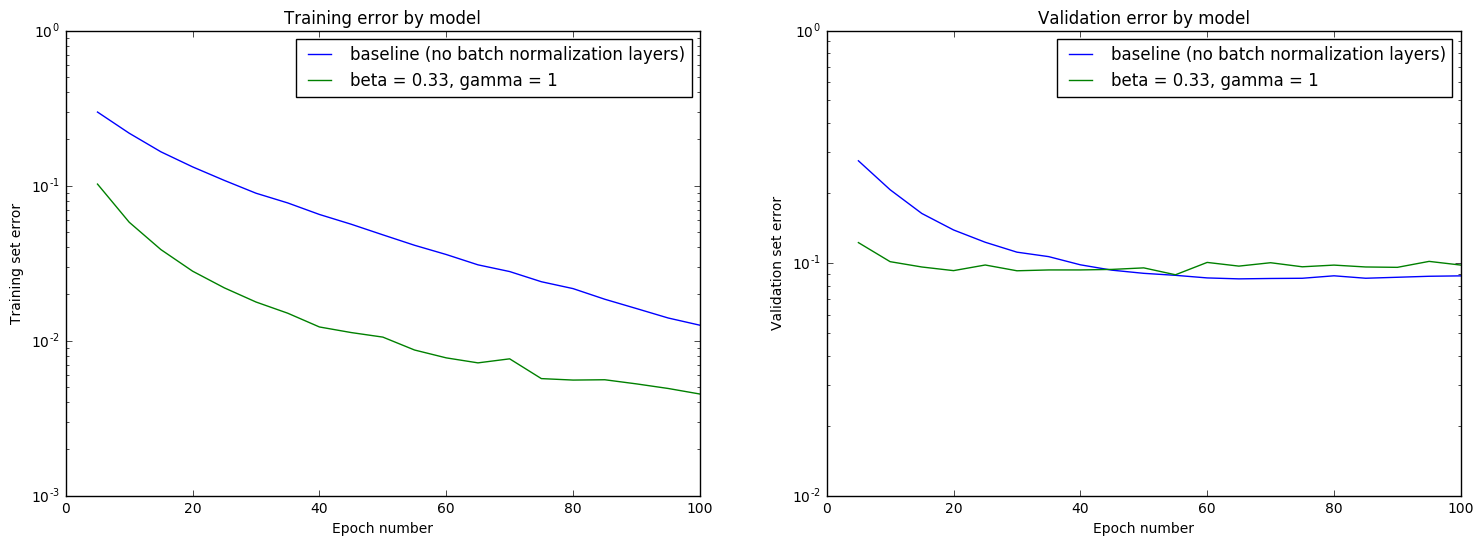

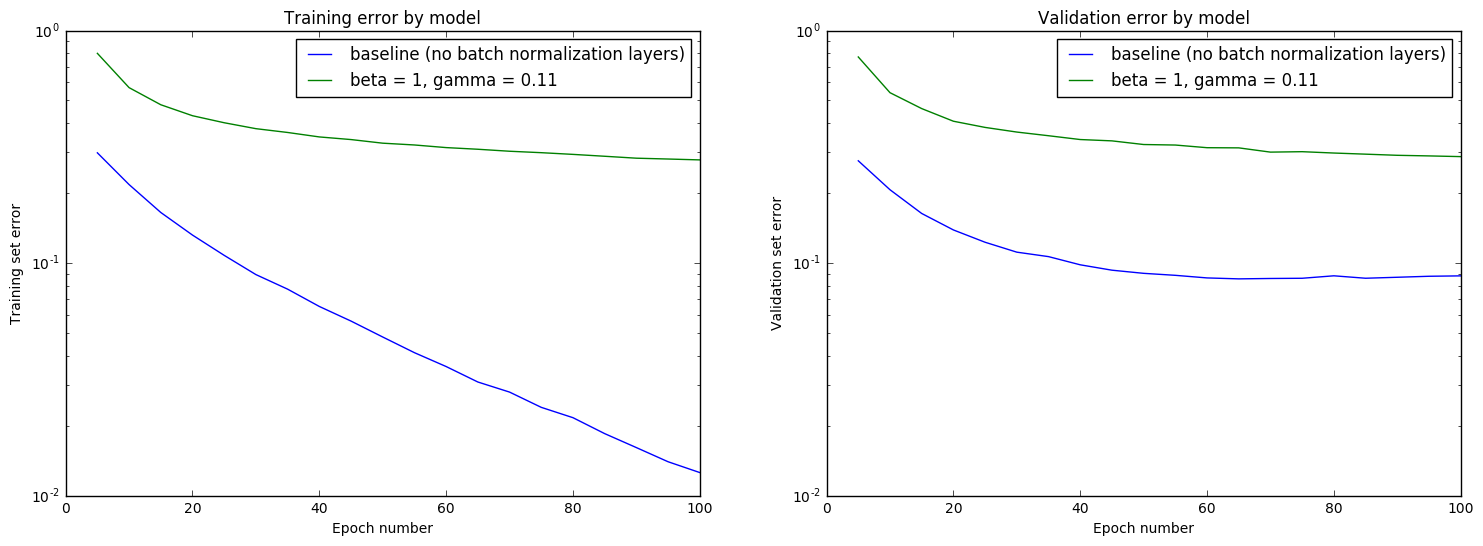

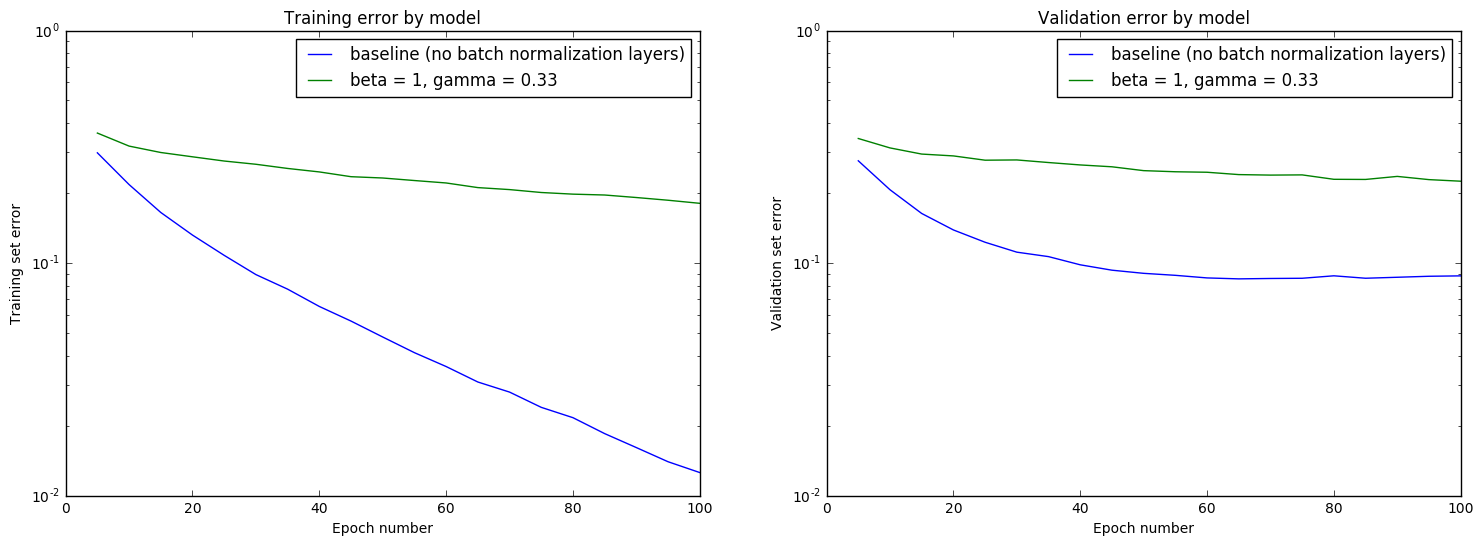

In [242]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'batch_norm'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Unpickle all important objects
run_infos = pickle.load(open(os.path.join(save_path_main, subdir, "run_infos.p"), "rb"))
# models    = pickle.load(open(os.path.join(save_path_main, subdir, "models.p"), "rb"))


# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# combos_to_plot_idx = [0, 1, 2]

for i in xrange(len(combos)):
    if i == 0:
        color = 'b'
        label = 'baseline model'
    else:
        color = '0.8'
        label = 'batch normalization model'
    stats, keys, run_time = run_infos[i]
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], color, label=label)
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], color, label=label)
# ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax1.set_title('Training error by model')
# ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
ax2.set_title('Validation error by model')

plt.savefig(os.path.join(save_path, 'gray_vs_baseline_blue.pdf'))
plt.show()



# Plot stuff

combos_to_plot_idxs = [[0, 3, 6, 9, 12], [0, 1, 2, 3]]
filenames = ['different_gammas.pdf', 'different_betas.pdf']
for combos_to_plot_idx, filename in zip(combos_to_plot_idxs, filenames):    
    
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for i in xrange(len(combos)):
        if i not in combos_to_plot_idx:
            continue
        stats, keys, run_time = run_infos[i]
        label = combo_strs_pretty[i]
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=label)
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=label)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax1.set_title('Training error by model')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')
    ax2.set_title('Validation error by model')

    plt.savefig(os.path.join(save_path, filename))
    plt.show()





for j in xrange(1, len(combos)):
            
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    for i in [0, j]:
        
        stats, keys, run_time = run_infos[i]
        
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=combo_strs_pretty[i])
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=combo_strs_pretty[i])
        ax1.legend(loc=0)
        ax1.set_xlabel('Epoch number')
        ax1.set_ylabel('Training set error')
        ax1.set_yscale('log')
        ax1.set_title('Training error by model')
        ax2.legend(loc=0)
        ax2.set_xlabel('Epoch number')
        ax2.set_ylabel('Validation set error')
        ax2.set_yscale('log')
        ax2.set_title('Validation error by model')

    plt.savefig(os.path.join(save_path, 'vs_baseline_' + combo_strs_pretty[i] + '.pdf'))
    plt.show()


In [220]:
error_keys = []
error_values = []
for key, value in run_infos.iteritems():
    if value is None:
        continue
    error_keys.append(key)
    stats, keys, run_time = value
    error_values.append(stats[:, keys['error(valid)']][-1])

# Create values to paste into Excel
print 'Sigma max'
for error_key in error_keys:
    print error_key[0]

print ''
print 'Proportion augmented'
for error_key in error_keys:
    print error_key[1]

print ''
print 'Validation error values'  
for error_value in error_values:
    print error_value

AttributeError: 'list' object has no attribute 'iteritems'